# Toxic Comments Classification by Using TF-IDF

In [71]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [73]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer

In [74]:
# 축약어 모음
APPOS = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "i would",
"i'd" : "i had",
"i'll" : "i will",
"i'm" : "i am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "i have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not"
}
# 불용어 모음
STOPWORDS = set(stopwords.words("english"))

lemmatizer = WordNetLemmatizer()
tokenizer = TweetTokenizer()

## 1. 데이터 로드

In [75]:
df = pd.read_csv('./data/train.csv')
df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
id               159571 non-null object
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [77]:
df.shape

(159571, 8)

In [78]:
def remain_label_txt(df):
    df['sum_of_toxic'] = df['toxic'] + df['severe_toxic'] + df['obscene'] + df['threat'] + df['insult'] + df['identity_hate']
    df['is_toxic'] = df['sum_of_toxic'].apply(lambda x: 0 if x < 1 else 1)
    df.drop(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'sum_of_toxic', 'id'], axis=1, inplace=True)

    return df

In [79]:
remain_label_txt(df)
df.head(10)

,comment_text,is_toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


## 2. EDA

## 2.1. 라벨 분포도

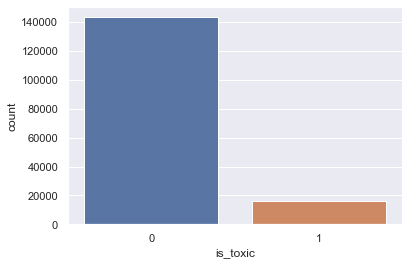

In [80]:
sns.countplot(x="is_toxic", data=df)
plt.show()

## 2.2. 텍스트 길이와 라벨의 관계

In [81]:
df['length'] = df['comment_text'].apply(len)
df.head(10)

,comment_text,is_toxic,length
0,Explanation\nWhy the edits made under my usern...,0,264
1,D'aww! He matches this background colour I'm s...,0,112
2,"Hey man, I'm really not trying to edit war. It...",0,233
3,"""\nMore\nI can't make any real suggestions on ...",0,622
4,"You, sir, are my hero. Any chance you remember...",0,67
5,"""\n\nCongratulations from me as well, use the ...",0,65
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,44
7,Your vandalism to the Matt Shirvington article...,0,115
8,Sorry if the word 'nonsense' was offensive to ...,0,472
9,alignment on this subject and which are contra...,0,70


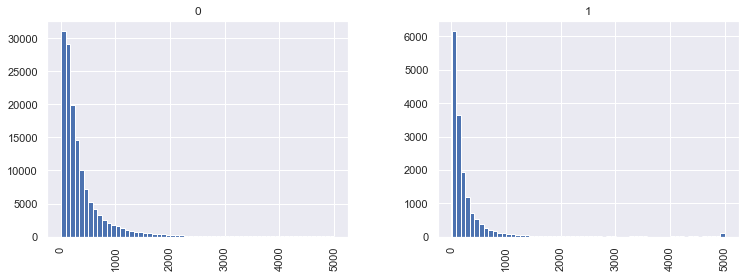

In [82]:
df.hist(column='length',by='is_toxic',bins=60,figsize=(12,4));

## 3. 데이터 전처리

In [83]:
# 쓸모없는 정보(개행, IP주소, USERNAME)을 제거하는 함수
def clean_useless(comment):
    comment = comment.lower()
    
    # 개행 제거
    comment = re.sub('\\n', " ", comment)
    # IP주소 제거
    comment = re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",comment)
    # USERNAME 제거
    comment = re.sub("\[\[.*\]","",comment)
    
    # 토큰화
    words = tokenizer.tokenize(comment)
    
    # 줄임말 풀이
    words = [APPOS[word] if word in APPOS else word for word in words]
    # 줄임말 다시 분리
    sent = " ".join(words)
    words = tokenizer.tokenize(sent)
    # stemming
    words = [lemmatizer.lemmatize(word, "v") for word in words]
    # Puctuation 제거
    words = [w for w in words if not w in string.punctuation]
    # 불용어 제거
    words = [w for w in words if not w in STOPWORDS]
    
    
    clean_sent = " ".join(words)
    
    return clean_sent

In [84]:
# 위의 함수를 적용하여 comment를 clean하게 만드는 함수
def get_clean_comment(df):
    df['comment_text'] = df['comment_text'].apply(lambda x: clean_useless(x))
    
    return df

In [85]:
df = get_clean_comment(df)
df.head(10)

,comment_text,is_toxic,length
0,explanation edit make username hardcore metall...,0,264
1,d'aww match background colour seemingly stick ...,0,112
2,hey man really try edit war guy constantly rem...,0,233
3,cannot make real suggestions improvement wonde...,0,622
4,sir hero chance remember page,0,67
5,congratulations well use tool well · talk,0,65
6,cocksucker piss around work,1,44
7,vandalism matt shirvington article revert plea...,0,115
8,sorry word nonsense offensive anyway intend wr...,0,472
9,alignment subject contrary dulithgow,0,70


In [86]:
df = df.drop(['length'], axis=1)
df.head(10)

,comment_text,is_toxic
0,explanation edit make username hardcore metall...,0
1,d'aww match background colour seemingly stick ...,0
2,hey man really try edit war guy constantly rem...,0
3,cannot make real suggestions improvement wonde...,0
4,sir hero chance remember page,0
5,congratulations well use tool well · talk,0
6,cocksucker piss around work,1
7,vandalism matt shirvington article revert plea...,0
8,sorry word nonsense offensive anyway intend wr...,0
9,alignment subject contrary dulithgow,0


## 4. 모델링 및 학습

In [88]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

tfidf_vect = TfidfVectorizer("english")
X_features = tfidf_vect.fit_transform(df['comment_text'])
y_labels = df['is_toxic']

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=0)

In [ ]:
params = {
    'num_leaves' : [32, 64],
    'max_depth' : [128, 160],
    'min_child_samples' : [60, 100],
    'subsample' : [0.8, 1],
    'n_estimators' : [300, 500]
}

lgbm_clf = LGBMClassifier()
gridcv = GridSearchCV(lgbm_clf, param_grid=params)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc", eval_set=[(X_train, y_train), (X_test, y_test)])
print('최적의 하이퍼 파라미터 모델 :', gridcv.best_params_)

[1]	valid_0's auc: 0.839172	valid_0's binary_logloss: 0.28186	valid_1's auc: 0.83399	valid_1's binary_logloss: 0.286123
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.866069	valid_0's binary_logloss: 0.26039	valid_1's auc: 0.858556	valid_1's binary_logloss: 0.264643
[3]	valid_0's auc: 0.870414	valid_0's binary_logloss: 0.245759	valid_1's auc: 0.862478	valid_1's binary_logloss: 0.249905
[4]	valid_0's auc: 0.881012	valid_0's binary_logloss: 0.234712	valid_1's auc: 0.872915	valid_1's binary_logloss: 0.23881
[5]	valid_0's auc: 0.887304	valid_0's binary_logloss: 0.225862	valid_1's auc: 0.878258	valid_1's binary_logloss: 0.230015
[6]	valid_0's auc: 0.90149	valid_0's binary_logloss: 0.21835	valid_1's auc: 0.89138	valid_1's binary_logloss: 0.222626
[7]	valid_0's auc: 0.901908	valid_0's binary_logloss: 0.212268	valid_1's auc: 0.891694	valid_1's binary_logloss: 0.21667
[8]	valid_0's auc: 0.906248	valid_0's binary_logloss: 0.207344	valid_1's auc: 0.895653	valid_

[68]	valid_0's auc: 0.962191	valid_0's binary_logloss: 0.128177	valid_1's auc: 0.948448	valid_1's binary_logloss: 0.140811
[69]	valid_0's auc: 0.962475	valid_0's binary_logloss: 0.127783	valid_1's auc: 0.948602	valid_1's binary_logloss: 0.140522
[70]	valid_0's auc: 0.962705	valid_0's binary_logloss: 0.127417	valid_1's auc: 0.948796	valid_1's binary_logloss: 0.140288
[71]	valid_0's auc: 0.963069	valid_0's binary_logloss: 0.127017	valid_1's auc: 0.949031	valid_1's binary_logloss: 0.139966
[72]	valid_0's auc: 0.963264	valid_0's binary_logloss: 0.126656	valid_1's auc: 0.949213	valid_1's binary_logloss: 0.139721
[73]	valid_0's auc: 0.963511	valid_0's binary_logloss: 0.126318	valid_1's auc: 0.949263	valid_1's binary_logloss: 0.139516
[74]	valid_0's auc: 0.963719	valid_0's binary_logloss: 0.125997	valid_1's auc: 0.94939	valid_1's binary_logloss: 0.139321
[75]	valid_0's auc: 0.963889	valid_0's binary_logloss: 0.125698	valid_1's auc: 0.949608	valid_1's binary_logloss: 0.139081
[76]	valid_0's au

[135]	valid_0's auc: 0.971848	valid_0's binary_logloss: 0.112198	valid_1's auc: 0.953857	valid_1's binary_logloss: 0.131777
[136]	valid_0's auc: 0.971944	valid_0's binary_logloss: 0.112051	valid_1's auc: 0.953876	valid_1's binary_logloss: 0.131702
[137]	valid_0's auc: 0.972056	valid_0's binary_logloss: 0.111891	valid_1's auc: 0.953942	valid_1's binary_logloss: 0.131644
[138]	valid_0's auc: 0.972102	valid_0's binary_logloss: 0.111753	valid_1's auc: 0.953945	valid_1's binary_logloss: 0.131598
[139]	valid_0's auc: 0.972196	valid_0's binary_logloss: 0.111607	valid_1's auc: 0.95394	valid_1's binary_logloss: 0.131543
[140]	valid_0's auc: 0.972266	valid_0's binary_logloss: 0.111467	valid_1's auc: 0.953987	valid_1's binary_logloss: 0.131496
[141]	valid_0's auc: 0.972389	valid_0's binary_logloss: 0.11129	valid_1's auc: 0.954008	valid_1's binary_logloss: 0.131445
[142]	valid_0's auc: 0.972479	valid_0's binary_logloss: 0.111126	valid_1's auc: 0.95409	valid_1's binary_logloss: 0.13136
[143]	valid_

[202]	valid_0's auc: 0.976296	valid_0's binary_logloss: 0.103797	valid_1's auc: 0.955147	valid_1's binary_logloss: 0.129373
[203]	valid_0's auc: 0.976335	valid_0's binary_logloss: 0.103704	valid_1's auc: 0.955142	valid_1's binary_logloss: 0.129356
[204]	valid_0's auc: 0.976362	valid_0's binary_logloss: 0.103612	valid_1's auc: 0.955164	valid_1's binary_logloss: 0.129314
[205]	valid_0's auc: 0.976408	valid_0's binary_logloss: 0.103518	valid_1's auc: 0.955191	valid_1's binary_logloss: 0.129285
[206]	valid_0's auc: 0.976482	valid_0's binary_logloss: 0.103408	valid_1's auc: 0.955162	valid_1's binary_logloss: 0.129282
[207]	valid_0's auc: 0.976525	valid_0's binary_logloss: 0.103312	valid_1's auc: 0.955144	valid_1's binary_logloss: 0.129277
[208]	valid_0's auc: 0.976579	valid_0's binary_logloss: 0.103216	valid_1's auc: 0.955087	valid_1's binary_logloss: 0.129266
[209]	valid_0's auc: 0.976612	valid_0's binary_logloss: 0.103123	valid_1's auc: 0.95509	valid_1's binary_logloss: 0.129207
[210]	val

[11]	valid_0's auc: 0.910724	valid_0's binary_logloss: 0.194775	valid_1's auc: 0.900992	valid_1's binary_logloss: 0.198842
[12]	valid_0's auc: 0.913457	valid_0's binary_logloss: 0.191532	valid_1's auc: 0.902861	valid_1's binary_logloss: 0.195899
[13]	valid_0's auc: 0.914956	valid_0's binary_logloss: 0.188352	valid_1's auc: 0.904617	valid_1's binary_logloss: 0.19281
[14]	valid_0's auc: 0.916063	valid_0's binary_logloss: 0.185495	valid_1's auc: 0.905216	valid_1's binary_logloss: 0.190189
[15]	valid_0's auc: 0.91843	valid_0's binary_logloss: 0.182683	valid_1's auc: 0.907055	valid_1's binary_logloss: 0.187662
[16]	valid_0's auc: 0.921127	valid_0's binary_logloss: 0.179852	valid_1's auc: 0.909612	valid_1's binary_logloss: 0.185027
[17]	valid_0's auc: 0.923596	valid_0's binary_logloss: 0.177651	valid_1's auc: 0.911914	valid_1's binary_logloss: 0.183105
[18]	valid_0's auc: 0.925638	valid_0's binary_logloss: 0.175272	valid_1's auc: 0.914008	valid_1's binary_logloss: 0.180848
[19]	valid_0's auc

[78]	valid_0's auc: 0.965196	valid_0's binary_logloss: 0.12549	valid_1's auc: 0.94955	valid_1's binary_logloss: 0.139055
[79]	valid_0's auc: 0.965426	valid_0's binary_logloss: 0.125159	valid_1's auc: 0.949529	valid_1's binary_logloss: 0.138885
[80]	valid_0's auc: 0.965585	valid_0's binary_logloss: 0.124872	valid_1's auc: 0.949633	valid_1's binary_logloss: 0.138672
[81]	valid_0's auc: 0.965746	valid_0's binary_logloss: 0.124564	valid_1's auc: 0.949765	valid_1's binary_logloss: 0.138437
[82]	valid_0's auc: 0.965925	valid_0's binary_logloss: 0.124271	valid_1's auc: 0.949892	valid_1's binary_logloss: 0.138291
[83]	valid_0's auc: 0.96606	valid_0's binary_logloss: 0.12401	valid_1's auc: 0.950022	valid_1's binary_logloss: 0.138126
[84]	valid_0's auc: 0.966318	valid_0's binary_logloss: 0.123715	valid_1's auc: 0.95019	valid_1's binary_logloss: 0.137889
[85]	valid_0's auc: 0.96648	valid_0's binary_logloss: 0.12343	valid_1's auc: 0.950357	valid_1's binary_logloss: 0.137636
[86]	valid_0's auc: 0.9

[145]	valid_0's auc: 0.973618	valid_0's binary_logloss: 0.111447	valid_1's auc: 0.954552	valid_1's binary_logloss: 0.131463
[146]	valid_0's auc: 0.973718	valid_0's binary_logloss: 0.111281	valid_1's auc: 0.954631	valid_1's binary_logloss: 0.13139
[147]	valid_0's auc: 0.973799	valid_0's binary_logloss: 0.111136	valid_1's auc: 0.954674	valid_1's binary_logloss: 0.131354
[148]	valid_0's auc: 0.973886	valid_0's binary_logloss: 0.110993	valid_1's auc: 0.954713	valid_1's binary_logloss: 0.131299
[149]	valid_0's auc: 0.973984	valid_0's binary_logloss: 0.110841	valid_1's auc: 0.954749	valid_1's binary_logloss: 0.131239
[150]	valid_0's auc: 0.974034	valid_0's binary_logloss: 0.110696	valid_1's auc: 0.954817	valid_1's binary_logloss: 0.131154
[151]	valid_0's auc: 0.974095	valid_0's binary_logloss: 0.110548	valid_1's auc: 0.954854	valid_1's binary_logloss: 0.131104
[152]	valid_0's auc: 0.974153	valid_0's binary_logloss: 0.110425	valid_1's auc: 0.954875	valid_1's binary_logloss: 0.131083
[153]	val

[212]	valid_0's auc: 0.977525	valid_0's binary_logloss: 0.103519	valid_1's auc: 0.956358	valid_1's binary_logloss: 0.128777
[213]	valid_0's auc: 0.977549	valid_0's binary_logloss: 0.103442	valid_1's auc: 0.956343	valid_1's binary_logloss: 0.128741
[214]	valid_0's auc: 0.977587	valid_0's binary_logloss: 0.103343	valid_1's auc: 0.95636	valid_1's binary_logloss: 0.128691
[215]	valid_0's auc: 0.977629	valid_0's binary_logloss: 0.103235	valid_1's auc: 0.956281	valid_1's binary_logloss: 0.12872
[216]	valid_0's auc: 0.977694	valid_0's binary_logloss: 0.103124	valid_1's auc: 0.95628	valid_1's binary_logloss: 0.128732
[217]	valid_0's auc: 0.977745	valid_0's binary_logloss: 0.103021	valid_1's auc: 0.956255	valid_1's binary_logloss: 0.128695
[218]	valid_0's auc: 0.977801	valid_0's binary_logloss: 0.10292	valid_1's auc: 0.956282	valid_1's binary_logloss: 0.128653
[219]	valid_0's auc: 0.97785	valid_0's binary_logloss: 0.10281	valid_1's auc: 0.956293	valid_1's binary_logloss: 0.128619
[220]	valid_0'

[33]	valid_0's auc: 0.945971	valid_0's binary_logloss: 0.15138	valid_1's auc: 0.934882	valid_1's binary_logloss: 0.159173
[34]	valid_0's auc: 0.946995	valid_0's binary_logloss: 0.150147	valid_1's auc: 0.935975	valid_1's binary_logloss: 0.158081
[35]	valid_0's auc: 0.947675	valid_0's binary_logloss: 0.149229	valid_1's auc: 0.936758	valid_1's binary_logloss: 0.157286
[36]	valid_0's auc: 0.94885	valid_0's binary_logloss: 0.14814	valid_1's auc: 0.93763	valid_1's binary_logloss: 0.156347
[37]	valid_0's auc: 0.949407	valid_0's binary_logloss: 0.147194	valid_1's auc: 0.938276	valid_1's binary_logloss: 0.155483
[38]	valid_0's auc: 0.950225	valid_0's binary_logloss: 0.14623	valid_1's auc: 0.939383	valid_1's binary_logloss: 0.154544
[39]	valid_0's auc: 0.950978	valid_0's binary_logloss: 0.14533	valid_1's auc: 0.939958	valid_1's binary_logloss: 0.153737
[40]	valid_0's auc: 0.951537	valid_0's binary_logloss: 0.14443	valid_1's auc: 0.940506	valid_1's binary_logloss: 0.152952
[41]	valid_0's auc: 0.9

[100]	valid_0's auc: 0.96813	valid_0's binary_logloss: 0.119317	valid_1's auc: 0.952906	valid_1's binary_logloss: 0.134596
[101]	valid_0's auc: 0.968257	valid_0's binary_logloss: 0.119118	valid_1's auc: 0.952918	valid_1's binary_logloss: 0.134499
[102]	valid_0's auc: 0.968392	valid_0's binary_logloss: 0.118887	valid_1's auc: 0.953032	valid_1's binary_logloss: 0.134372
[103]	valid_0's auc: 0.968547	valid_0's binary_logloss: 0.118668	valid_1's auc: 0.95311	valid_1's binary_logloss: 0.134259
[104]	valid_0's auc: 0.968674	valid_0's binary_logloss: 0.118441	valid_1's auc: 0.953172	valid_1's binary_logloss: 0.134114
[105]	valid_0's auc: 0.968776	valid_0's binary_logloss: 0.118238	valid_1's auc: 0.953264	valid_1's binary_logloss: 0.13403
[106]	valid_0's auc: 0.968869	valid_0's binary_logloss: 0.118029	valid_1's auc: 0.953295	valid_1's binary_logloss: 0.133932
[107]	valid_0's auc: 0.968978	valid_0's binary_logloss: 0.117845	valid_1's auc: 0.953313	valid_1's binary_logloss: 0.133834
[108]	valid

[167]	valid_0's auc: 0.974266	valid_0's binary_logloss: 0.108252	valid_1's auc: 0.955221	valid_1's binary_logloss: 0.129759
[168]	valid_0's auc: 0.974329	valid_0's binary_logloss: 0.108121	valid_1's auc: 0.955248	valid_1's binary_logloss: 0.129697
[169]	valid_0's auc: 0.974399	valid_0's binary_logloss: 0.107996	valid_1's auc: 0.955283	valid_1's binary_logloss: 0.129635
[170]	valid_0's auc: 0.974435	valid_0's binary_logloss: 0.107898	valid_1's auc: 0.955271	valid_1's binary_logloss: 0.129618
[171]	valid_0's auc: 0.974498	valid_0's binary_logloss: 0.107763	valid_1's auc: 0.955278	valid_1's binary_logloss: 0.129565
[172]	valid_0's auc: 0.974574	valid_0's binary_logloss: 0.107653	valid_1's auc: 0.955316	valid_1's binary_logloss: 0.129523
[173]	valid_0's auc: 0.974638	valid_0's binary_logloss: 0.10753	valid_1's auc: 0.955263	valid_1's binary_logloss: 0.129502
[174]	valid_0's auc: 0.974699	valid_0's binary_logloss: 0.107404	valid_1's auc: 0.955306	valid_1's binary_logloss: 0.129469
[175]	val

[234]	valid_0's auc: 0.977544	valid_0's binary_logloss: 0.101349	valid_1's auc: 0.956016	valid_1's binary_logloss: 0.12795
[235]	valid_0's auc: 0.977564	valid_0's binary_logloss: 0.101272	valid_1's auc: 0.95605	valid_1's binary_logloss: 0.127923
[236]	valid_0's auc: 0.977594	valid_0's binary_logloss: 0.101177	valid_1's auc: 0.956041	valid_1's binary_logloss: 0.127905
[237]	valid_0's auc: 0.977632	valid_0's binary_logloss: 0.1011	valid_1's auc: 0.956042	valid_1's binary_logloss: 0.127886
[238]	valid_0's auc: 0.977651	valid_0's binary_logloss: 0.101031	valid_1's auc: 0.956061	valid_1's binary_logloss: 0.127856
[239]	valid_0's auc: 0.977686	valid_0's binary_logloss: 0.100954	valid_1's auc: 0.956078	valid_1's binary_logloss: 0.127852
[240]	valid_0's auc: 0.977728	valid_0's binary_logloss: 0.10087	valid_1's auc: 0.956071	valid_1's binary_logloss: 0.127842
[241]	valid_0's auc: 0.977756	valid_0's binary_logloss: 0.100791	valid_1's auc: 0.956053	valid_1's binary_logloss: 0.127827
[242]	valid_0

[2]	valid_0's auc: 0.866069	valid_0's binary_logloss: 0.26039	valid_1's auc: 0.858556	valid_1's binary_logloss: 0.264643
[3]	valid_0's auc: 0.870414	valid_0's binary_logloss: 0.245759	valid_1's auc: 0.862478	valid_1's binary_logloss: 0.249905
[4]	valid_0's auc: 0.881012	valid_0's binary_logloss: 0.234712	valid_1's auc: 0.872915	valid_1's binary_logloss: 0.23881
[5]	valid_0's auc: 0.887304	valid_0's binary_logloss: 0.225862	valid_1's auc: 0.878258	valid_1's binary_logloss: 0.230015
[6]	valid_0's auc: 0.90149	valid_0's binary_logloss: 0.21835	valid_1's auc: 0.89138	valid_1's binary_logloss: 0.222626
[7]	valid_0's auc: 0.901908	valid_0's binary_logloss: 0.212268	valid_1's auc: 0.891694	valid_1's binary_logloss: 0.21667
[8]	valid_0's auc: 0.906248	valid_0's binary_logloss: 0.207344	valid_1's auc: 0.895653	valid_1's binary_logloss: 0.211865
[9]	valid_0's auc: 0.90792	valid_0's binary_logloss: 0.202684	valid_1's auc: 0.897573	valid_1's binary_logloss: 0.207288
[10]	valid_0's auc: 0.909544	va

[69]	valid_0's auc: 0.962475	valid_0's binary_logloss: 0.127783	valid_1's auc: 0.948602	valid_1's binary_logloss: 0.140522
[70]	valid_0's auc: 0.962705	valid_0's binary_logloss: 0.127417	valid_1's auc: 0.948796	valid_1's binary_logloss: 0.140288
[71]	valid_0's auc: 0.963069	valid_0's binary_logloss: 0.127017	valid_1's auc: 0.949031	valid_1's binary_logloss: 0.139966
[72]	valid_0's auc: 0.963264	valid_0's binary_logloss: 0.126656	valid_1's auc: 0.949213	valid_1's binary_logloss: 0.139721
[73]	valid_0's auc: 0.963511	valid_0's binary_logloss: 0.126318	valid_1's auc: 0.949263	valid_1's binary_logloss: 0.139516
[74]	valid_0's auc: 0.963719	valid_0's binary_logloss: 0.125997	valid_1's auc: 0.94939	valid_1's binary_logloss: 0.139321
[75]	valid_0's auc: 0.963889	valid_0's binary_logloss: 0.125698	valid_1's auc: 0.949608	valid_1's binary_logloss: 0.139081
[76]	valid_0's auc: 0.964096	valid_0's binary_logloss: 0.125381	valid_1's auc: 0.949782	valid_1's binary_logloss: 0.138916
[77]	valid_0's au

[136]	valid_0's auc: 0.971944	valid_0's binary_logloss: 0.112051	valid_1's auc: 0.953876	valid_1's binary_logloss: 0.131702
[137]	valid_0's auc: 0.972056	valid_0's binary_logloss: 0.111891	valid_1's auc: 0.953942	valid_1's binary_logloss: 0.131644
[138]	valid_0's auc: 0.972102	valid_0's binary_logloss: 0.111753	valid_1's auc: 0.953945	valid_1's binary_logloss: 0.131598
[139]	valid_0's auc: 0.972196	valid_0's binary_logloss: 0.111607	valid_1's auc: 0.95394	valid_1's binary_logloss: 0.131543
[140]	valid_0's auc: 0.972266	valid_0's binary_logloss: 0.111467	valid_1's auc: 0.953987	valid_1's binary_logloss: 0.131496
[141]	valid_0's auc: 0.972389	valid_0's binary_logloss: 0.11129	valid_1's auc: 0.954008	valid_1's binary_logloss: 0.131445
[142]	valid_0's auc: 0.972479	valid_0's binary_logloss: 0.111126	valid_1's auc: 0.95409	valid_1's binary_logloss: 0.13136
[143]	valid_0's auc: 0.972559	valid_0's binary_logloss: 0.110979	valid_1's auc: 0.954132	valid_1's binary_logloss: 0.131318
[144]	valid_

[203]	valid_0's auc: 0.976335	valid_0's binary_logloss: 0.103704	valid_1's auc: 0.955142	valid_1's binary_logloss: 0.129356
[204]	valid_0's auc: 0.976362	valid_0's binary_logloss: 0.103612	valid_1's auc: 0.955164	valid_1's binary_logloss: 0.129314
[205]	valid_0's auc: 0.976408	valid_0's binary_logloss: 0.103518	valid_1's auc: 0.955191	valid_1's binary_logloss: 0.129285
[206]	valid_0's auc: 0.976482	valid_0's binary_logloss: 0.103408	valid_1's auc: 0.955162	valid_1's binary_logloss: 0.129282
[207]	valid_0's auc: 0.976525	valid_0's binary_logloss: 0.103312	valid_1's auc: 0.955144	valid_1's binary_logloss: 0.129277
[208]	valid_0's auc: 0.976579	valid_0's binary_logloss: 0.103216	valid_1's auc: 0.955087	valid_1's binary_logloss: 0.129266
[209]	valid_0's auc: 0.976612	valid_0's binary_logloss: 0.103123	valid_1's auc: 0.95509	valid_1's binary_logloss: 0.129207
[210]	valid_0's auc: 0.97664	valid_0's binary_logloss: 0.103043	valid_1's auc: 0.955129	valid_1's binary_logloss: 0.129158
[211]	vali

[12]	valid_0's auc: 0.913457	valid_0's binary_logloss: 0.191532	valid_1's auc: 0.902861	valid_1's binary_logloss: 0.195899
[13]	valid_0's auc: 0.914956	valid_0's binary_logloss: 0.188352	valid_1's auc: 0.904617	valid_1's binary_logloss: 0.19281
[14]	valid_0's auc: 0.916063	valid_0's binary_logloss: 0.185495	valid_1's auc: 0.905216	valid_1's binary_logloss: 0.190189
[15]	valid_0's auc: 0.91843	valid_0's binary_logloss: 0.182683	valid_1's auc: 0.907055	valid_1's binary_logloss: 0.187662
[16]	valid_0's auc: 0.921127	valid_0's binary_logloss: 0.179852	valid_1's auc: 0.909612	valid_1's binary_logloss: 0.185027
[17]	valid_0's auc: 0.923596	valid_0's binary_logloss: 0.177651	valid_1's auc: 0.911914	valid_1's binary_logloss: 0.183105
[18]	valid_0's auc: 0.925638	valid_0's binary_logloss: 0.175272	valid_1's auc: 0.914008	valid_1's binary_logloss: 0.180848
[19]	valid_0's auc: 0.927287	valid_0's binary_logloss: 0.173034	valid_1's auc: 0.91528	valid_1's binary_logloss: 0.178795
[20]	valid_0's auc:

[79]	valid_0's auc: 0.965426	valid_0's binary_logloss: 0.125159	valid_1's auc: 0.949529	valid_1's binary_logloss: 0.138885
[80]	valid_0's auc: 0.965585	valid_0's binary_logloss: 0.124872	valid_1's auc: 0.949633	valid_1's binary_logloss: 0.138672
[81]	valid_0's auc: 0.965746	valid_0's binary_logloss: 0.124564	valid_1's auc: 0.949765	valid_1's binary_logloss: 0.138437
[82]	valid_0's auc: 0.965925	valid_0's binary_logloss: 0.124271	valid_1's auc: 0.949892	valid_1's binary_logloss: 0.138291
[83]	valid_0's auc: 0.96606	valid_0's binary_logloss: 0.12401	valid_1's auc: 0.950022	valid_1's binary_logloss: 0.138126
[84]	valid_0's auc: 0.966318	valid_0's binary_logloss: 0.123715	valid_1's auc: 0.95019	valid_1's binary_logloss: 0.137889
[85]	valid_0's auc: 0.96648	valid_0's binary_logloss: 0.12343	valid_1's auc: 0.950357	valid_1's binary_logloss: 0.137636
[86]	valid_0's auc: 0.966691	valid_0's binary_logloss: 0.123144	valid_1's auc: 0.950501	valid_1's binary_logloss: 0.13749
[87]	valid_0's auc: 0.

[146]	valid_0's auc: 0.973718	valid_0's binary_logloss: 0.111281	valid_1's auc: 0.954631	valid_1's binary_logloss: 0.13139
[147]	valid_0's auc: 0.973799	valid_0's binary_logloss: 0.111136	valid_1's auc: 0.954674	valid_1's binary_logloss: 0.131354
[148]	valid_0's auc: 0.973886	valid_0's binary_logloss: 0.110993	valid_1's auc: 0.954713	valid_1's binary_logloss: 0.131299
[149]	valid_0's auc: 0.973984	valid_0's binary_logloss: 0.110841	valid_1's auc: 0.954749	valid_1's binary_logloss: 0.131239
[150]	valid_0's auc: 0.974034	valid_0's binary_logloss: 0.110696	valid_1's auc: 0.954817	valid_1's binary_logloss: 0.131154
[151]	valid_0's auc: 0.974095	valid_0's binary_logloss: 0.110548	valid_1's auc: 0.954854	valid_1's binary_logloss: 0.131104
[152]	valid_0's auc: 0.974153	valid_0's binary_logloss: 0.110425	valid_1's auc: 0.954875	valid_1's binary_logloss: 0.131083
[153]	valid_0's auc: 0.97422	valid_0's binary_logloss: 0.110291	valid_1's auc: 0.954993	valid_1's binary_logloss: 0.130986
[154]	vali

[213]	valid_0's auc: 0.977549	valid_0's binary_logloss: 0.103442	valid_1's auc: 0.956343	valid_1's binary_logloss: 0.128741
[214]	valid_0's auc: 0.977587	valid_0's binary_logloss: 0.103343	valid_1's auc: 0.95636	valid_1's binary_logloss: 0.128691
[215]	valid_0's auc: 0.977629	valid_0's binary_logloss: 0.103235	valid_1's auc: 0.956281	valid_1's binary_logloss: 0.12872
[216]	valid_0's auc: 0.977694	valid_0's binary_logloss: 0.103124	valid_1's auc: 0.95628	valid_1's binary_logloss: 0.128732
[217]	valid_0's auc: 0.977745	valid_0's binary_logloss: 0.103021	valid_1's auc: 0.956255	valid_1's binary_logloss: 0.128695
[218]	valid_0's auc: 0.977801	valid_0's binary_logloss: 0.10292	valid_1's auc: 0.956282	valid_1's binary_logloss: 0.128653
[219]	valid_0's auc: 0.97785	valid_0's binary_logloss: 0.10281	valid_1's auc: 0.956293	valid_1's binary_logloss: 0.128619
[220]	valid_0's auc: 0.977886	valid_0's binary_logloss: 0.102725	valid_1's auc: 0.956301	valid_1's binary_logloss: 0.128592
[221]	valid_0'

[34]	valid_0's auc: 0.946995	valid_0's binary_logloss: 0.150147	valid_1's auc: 0.935975	valid_1's binary_logloss: 0.158081
[35]	valid_0's auc: 0.947675	valid_0's binary_logloss: 0.149229	valid_1's auc: 0.936758	valid_1's binary_logloss: 0.157286
[36]	valid_0's auc: 0.94885	valid_0's binary_logloss: 0.14814	valid_1's auc: 0.93763	valid_1's binary_logloss: 0.156347
[37]	valid_0's auc: 0.949407	valid_0's binary_logloss: 0.147194	valid_1's auc: 0.938276	valid_1's binary_logloss: 0.155483
[38]	valid_0's auc: 0.950225	valid_0's binary_logloss: 0.14623	valid_1's auc: 0.939383	valid_1's binary_logloss: 0.154544
[39]	valid_0's auc: 0.950978	valid_0's binary_logloss: 0.14533	valid_1's auc: 0.939958	valid_1's binary_logloss: 0.153737
[40]	valid_0's auc: 0.951537	valid_0's binary_logloss: 0.14443	valid_1's auc: 0.940506	valid_1's binary_logloss: 0.152952
[41]	valid_0's auc: 0.952082	valid_0's binary_logloss: 0.143569	valid_1's auc: 0.940903	valid_1's binary_logloss: 0.152213
[42]	valid_0's auc: 0.

[101]	valid_0's auc: 0.968257	valid_0's binary_logloss: 0.119118	valid_1's auc: 0.952918	valid_1's binary_logloss: 0.134499
[102]	valid_0's auc: 0.968392	valid_0's binary_logloss: 0.118887	valid_1's auc: 0.953032	valid_1's binary_logloss: 0.134372
[103]	valid_0's auc: 0.968547	valid_0's binary_logloss: 0.118668	valid_1's auc: 0.95311	valid_1's binary_logloss: 0.134259
[104]	valid_0's auc: 0.968674	valid_0's binary_logloss: 0.118441	valid_1's auc: 0.953172	valid_1's binary_logloss: 0.134114
[105]	valid_0's auc: 0.968776	valid_0's binary_logloss: 0.118238	valid_1's auc: 0.953264	valid_1's binary_logloss: 0.13403
[106]	valid_0's auc: 0.968869	valid_0's binary_logloss: 0.118029	valid_1's auc: 0.953295	valid_1's binary_logloss: 0.133932
[107]	valid_0's auc: 0.968978	valid_0's binary_logloss: 0.117845	valid_1's auc: 0.953313	valid_1's binary_logloss: 0.133834
[108]	valid_0's auc: 0.969099	valid_0's binary_logloss: 0.117632	valid_1's auc: 0.953317	valid_1's binary_logloss: 0.13376
[109]	valid

[168]	valid_0's auc: 0.974329	valid_0's binary_logloss: 0.108121	valid_1's auc: 0.955248	valid_1's binary_logloss: 0.129697
[169]	valid_0's auc: 0.974399	valid_0's binary_logloss: 0.107996	valid_1's auc: 0.955283	valid_1's binary_logloss: 0.129635
[170]	valid_0's auc: 0.974435	valid_0's binary_logloss: 0.107898	valid_1's auc: 0.955271	valid_1's binary_logloss: 0.129618
[171]	valid_0's auc: 0.974498	valid_0's binary_logloss: 0.107763	valid_1's auc: 0.955278	valid_1's binary_logloss: 0.129565
[172]	valid_0's auc: 0.974574	valid_0's binary_logloss: 0.107653	valid_1's auc: 0.955316	valid_1's binary_logloss: 0.129523
[173]	valid_0's auc: 0.974638	valid_0's binary_logloss: 0.10753	valid_1's auc: 0.955263	valid_1's binary_logloss: 0.129502
[174]	valid_0's auc: 0.974699	valid_0's binary_logloss: 0.107404	valid_1's auc: 0.955306	valid_1's binary_logloss: 0.129469
[175]	valid_0's auc: 0.97476	valid_0's binary_logloss: 0.107288	valid_1's auc: 0.955328	valid_1's binary_logloss: 0.129453
[176]	vali

[235]	valid_0's auc: 0.977564	valid_0's binary_logloss: 0.101272	valid_1's auc: 0.95605	valid_1's binary_logloss: 0.127923
[236]	valid_0's auc: 0.977594	valid_0's binary_logloss: 0.101177	valid_1's auc: 0.956041	valid_1's binary_logloss: 0.127905
[237]	valid_0's auc: 0.977632	valid_0's binary_logloss: 0.1011	valid_1's auc: 0.956042	valid_1's binary_logloss: 0.127886
[238]	valid_0's auc: 0.977651	valid_0's binary_logloss: 0.101031	valid_1's auc: 0.956061	valid_1's binary_logloss: 0.127856
[239]	valid_0's auc: 0.977686	valid_0's binary_logloss: 0.100954	valid_1's auc: 0.956078	valid_1's binary_logloss: 0.127852
[240]	valid_0's auc: 0.977728	valid_0's binary_logloss: 0.10087	valid_1's auc: 0.956071	valid_1's binary_logloss: 0.127842
[241]	valid_0's auc: 0.977756	valid_0's binary_logloss: 0.100791	valid_1's auc: 0.956053	valid_1's binary_logloss: 0.127827
[242]	valid_0's auc: 0.977806	valid_0's binary_logloss: 0.100712	valid_1's auc: 0.956049	valid_1's binary_logloss: 0.127794
[243]	valid_

[3]	valid_0's auc: 0.911165	valid_0's binary_logloss: 0.239928	valid_1's auc: 0.898477	valid_1's binary_logloss: 0.245011
[4]	valid_0's auc: 0.914983	valid_0's binary_logloss: 0.228154	valid_1's auc: 0.902141	valid_1's binary_logloss: 0.233283
[5]	valid_0's auc: 0.916585	valid_0's binary_logloss: 0.218512	valid_1's auc: 0.904068	valid_1's binary_logloss: 0.223816
[6]	valid_0's auc: 0.917988	valid_0's binary_logloss: 0.210689	valid_1's auc: 0.905189	valid_1's binary_logloss: 0.21617
[7]	valid_0's auc: 0.920689	valid_0's binary_logloss: 0.203575	valid_1's auc: 0.907482	valid_1's binary_logloss: 0.209191
[8]	valid_0's auc: 0.922641	valid_0's binary_logloss: 0.197913	valid_1's auc: 0.909252	valid_1's binary_logloss: 0.203636
[9]	valid_0's auc: 0.924336	valid_0's binary_logloss: 0.192989	valid_1's auc: 0.911404	valid_1's binary_logloss: 0.198754
[10]	valid_0's auc: 0.926327	valid_0's binary_logloss: 0.188627	valid_1's auc: 0.913097	valid_1's binary_logloss: 0.194689
[11]	valid_0's auc: 0.92

[70]	valid_0's auc: 0.971497	valid_0's binary_logloss: 0.112487	valid_1's auc: 0.953873	valid_1's binary_logloss: 0.132339
[71]	valid_0's auc: 0.971737	valid_0's binary_logloss: 0.112106	valid_1's auc: 0.95395	valid_1's binary_logloss: 0.132172
[72]	valid_0's auc: 0.971918	valid_0's binary_logloss: 0.111752	valid_1's auc: 0.953959	valid_1's binary_logloss: 0.132045
[73]	valid_0's auc: 0.972082	valid_0's binary_logloss: 0.111376	valid_1's auc: 0.954014	valid_1's binary_logloss: 0.131902
[74]	valid_0's auc: 0.972266	valid_0's binary_logloss: 0.111025	valid_1's auc: 0.954099	valid_1's binary_logloss: 0.131759
[75]	valid_0's auc: 0.972426	valid_0's binary_logloss: 0.110702	valid_1's auc: 0.954138	valid_1's binary_logloss: 0.131691
[76]	valid_0's auc: 0.972664	valid_0's binary_logloss: 0.110377	valid_1's auc: 0.954277	valid_1's binary_logloss: 0.131542
[77]	valid_0's auc: 0.972868	valid_0's binary_logloss: 0.110044	valid_1's auc: 0.95439	valid_1's binary_logloss: 0.131378
[78]	valid_0's auc

[137]	valid_0's auc: 0.979037	valid_0's binary_logloss: 0.0967284	valid_1's auc: 0.955581	valid_1's binary_logloss: 0.128347
[138]	valid_0's auc: 0.979081	valid_0's binary_logloss: 0.0965679	valid_1's auc: 0.955564	valid_1's binary_logloss: 0.128346
[139]	valid_0's auc: 0.979144	valid_0's binary_logloss: 0.0963938	valid_1's auc: 0.955549	valid_1's binary_logloss: 0.128314
[140]	valid_0's auc: 0.979202	valid_0's binary_logloss: 0.0962489	valid_1's auc: 0.955501	valid_1's binary_logloss: 0.128319
[141]	valid_0's auc: 0.979248	valid_0's binary_logloss: 0.0961113	valid_1's auc: 0.955458	valid_1's binary_logloss: 0.12834
[142]	valid_0's auc: 0.979316	valid_0's binary_logloss: 0.0959593	valid_1's auc: 0.955502	valid_1's binary_logloss: 0.12828
[143]	valid_0's auc: 0.979371	valid_0's binary_logloss: 0.095815	valid_1's auc: 0.955497	valid_1's binary_logloss: 0.12828
[144]	valid_0's auc: 0.979441	valid_0's binary_logloss: 0.0956338	valid_1's auc: 0.955499	valid_1's binary_logloss: 0.128292
[145

[47]	valid_0's auc: 0.965824	valid_0's binary_logloss: 0.124212	valid_1's auc: 0.94914	valid_1's binary_logloss: 0.139175
[48]	valid_0's auc: 0.966102	valid_0's binary_logloss: 0.123556	valid_1's auc: 0.949374	valid_1's binary_logloss: 0.138739
[49]	valid_0's auc: 0.966458	valid_0's binary_logloss: 0.122944	valid_1's auc: 0.949802	valid_1's binary_logloss: 0.138331
[50]	valid_0's auc: 0.966831	valid_0's binary_logloss: 0.122304	valid_1's auc: 0.950124	valid_1's binary_logloss: 0.137863
[51]	valid_0's auc: 0.967155	valid_0's binary_logloss: 0.121712	valid_1's auc: 0.950216	valid_1's binary_logloss: 0.137556
[52]	valid_0's auc: 0.967495	valid_0's binary_logloss: 0.121119	valid_1's auc: 0.950405	valid_1's binary_logloss: 0.137194
[53]	valid_0's auc: 0.967887	valid_0's binary_logloss: 0.120545	valid_1's auc: 0.950617	valid_1's binary_logloss: 0.136904
[54]	valid_0's auc: 0.968198	valid_0's binary_logloss: 0.119997	valid_1's auc: 0.950937	valid_1's binary_logloss: 0.13662
[55]	valid_0's auc

[114]	valid_0's auc: 0.978	valid_0's binary_logloss: 0.100945	valid_1's auc: 0.956235	valid_1's binary_logloss: 0.128443
[115]	valid_0's auc: 0.978076	valid_0's binary_logloss: 0.100766	valid_1's auc: 0.956322	valid_1's binary_logloss: 0.128376
[116]	valid_0's auc: 0.97815	valid_0's binary_logloss: 0.100577	valid_1's auc: 0.956299	valid_1's binary_logloss: 0.128332
[117]	valid_0's auc: 0.978265	valid_0's binary_logloss: 0.100362	valid_1's auc: 0.956335	valid_1's binary_logloss: 0.128271
[118]	valid_0's auc: 0.978362	valid_0's binary_logloss: 0.100149	valid_1's auc: 0.956308	valid_1's binary_logloss: 0.128268
[119]	valid_0's auc: 0.978466	valid_0's binary_logloss: 0.0999384	valid_1's auc: 0.95626	valid_1's binary_logloss: 0.128261
[120]	valid_0's auc: 0.978574	valid_0's binary_logloss: 0.0997322	valid_1's auc: 0.9563	valid_1's binary_logloss: 0.128226
[121]	valid_0's auc: 0.978648	valid_0's binary_logloss: 0.0995395	valid_1's auc: 0.956362	valid_1's binary_logloss: 0.128171
[122]	valid_

[20]	valid_0's auc: 0.942234	valid_0's binary_logloss: 0.15907	valid_1's auc: 0.928899	valid_1's binary_logloss: 0.166995
[21]	valid_0's auc: 0.943599	valid_0's binary_logloss: 0.157111	valid_1's auc: 0.930416	valid_1's binary_logloss: 0.165174
[22]	valid_0's auc: 0.945162	valid_0's binary_logloss: 0.15487	valid_1's auc: 0.932244	valid_1's binary_logloss: 0.163177
[23]	valid_0's auc: 0.946497	valid_0's binary_logloss: 0.153078	valid_1's auc: 0.933035	valid_1's binary_logloss: 0.161655
[24]	valid_0's auc: 0.947906	valid_0's binary_logloss: 0.151117	valid_1's auc: 0.934998	valid_1's binary_logloss: 0.159821
[25]	valid_0's auc: 0.948955	valid_0's binary_logloss: 0.149273	valid_1's auc: 0.936181	valid_1's binary_logloss: 0.158159
[26]	valid_0's auc: 0.949946	valid_0's binary_logloss: 0.147723	valid_1's auc: 0.937206	valid_1's binary_logloss: 0.156825
[27]	valid_0's auc: 0.951099	valid_0's binary_logloss: 0.14597	valid_1's auc: 0.938445	valid_1's binary_logloss: 0.155252
[28]	valid_0's auc:

[87]	valid_0's auc: 0.97425	valid_0's binary_logloss: 0.107419	valid_1's auc: 0.955226	valid_1's binary_logloss: 0.129843
[88]	valid_0's auc: 0.974377	valid_0's binary_logloss: 0.107146	valid_1's auc: 0.955212	valid_1's binary_logloss: 0.129757
[89]	valid_0's auc: 0.974482	valid_0's binary_logloss: 0.10691	valid_1's auc: 0.955157	valid_1's binary_logloss: 0.129758
[90]	valid_0's auc: 0.97462	valid_0's binary_logloss: 0.106627	valid_1's auc: 0.955354	valid_1's binary_logloss: 0.129612
[91]	valid_0's auc: 0.974759	valid_0's binary_logloss: 0.106367	valid_1's auc: 0.955459	valid_1's binary_logloss: 0.129458
[92]	valid_0's auc: 0.974881	valid_0's binary_logloss: 0.106125	valid_1's auc: 0.955582	valid_1's binary_logloss: 0.129333
[93]	valid_0's auc: 0.97503	valid_0's binary_logloss: 0.105845	valid_1's auc: 0.955567	valid_1's binary_logloss: 0.129241
[94]	valid_0's auc: 0.975137	valid_0's binary_logloss: 0.105587	valid_1's auc: 0.955597	valid_1's binary_logloss: 0.129151
[95]	valid_0's auc: 

[154]	valid_0's auc: 0.979598	valid_0's binary_logloss: 0.0946778	valid_1's auc: 0.956506	valid_1's binary_logloss: 0.127191
[155]	valid_0's auc: 0.979666	valid_0's binary_logloss: 0.0945147	valid_1's auc: 0.956505	valid_1's binary_logloss: 0.12717
[156]	valid_0's auc: 0.979712	valid_0's binary_logloss: 0.0943844	valid_1's auc: 0.956471	valid_1's binary_logloss: 0.127192
[157]	valid_0's auc: 0.979792	valid_0's binary_logloss: 0.094219	valid_1's auc: 0.956458	valid_1's binary_logloss: 0.127166
[158]	valid_0's auc: 0.979831	valid_0's binary_logloss: 0.0940938	valid_1's auc: 0.9564	valid_1's binary_logloss: 0.127169
[159]	valid_0's auc: 0.979898	valid_0's binary_logloss: 0.0939611	valid_1's auc: 0.956421	valid_1's binary_logloss: 0.127131
[160]	valid_0's auc: 0.979952	valid_0's binary_logloss: 0.0938272	valid_1's auc: 0.956398	valid_1's binary_logloss: 0.127132
[161]	valid_0's auc: 0.979991	valid_0's binary_logloss: 0.0937044	valid_1's auc: 0.956439	valid_1's binary_logloss: 0.127139
[162

[48]	valid_0's auc: 0.965247	valid_0's binary_logloss: 0.123249	valid_1's auc: 0.949906	valid_1's binary_logloss: 0.13795
[49]	valid_0's auc: 0.965594	valid_0's binary_logloss: 0.122591	valid_1's auc: 0.950324	valid_1's binary_logloss: 0.137558
[50]	valid_0's auc: 0.966017	valid_0's binary_logloss: 0.121974	valid_1's auc: 0.950505	valid_1's binary_logloss: 0.137242
[51]	valid_0's auc: 0.966252	valid_0's binary_logloss: 0.121396	valid_1's auc: 0.950769	valid_1's binary_logloss: 0.136832
[52]	valid_0's auc: 0.966594	valid_0's binary_logloss: 0.120818	valid_1's auc: 0.951026	valid_1's binary_logloss: 0.136575
[53]	valid_0's auc: 0.966961	valid_0's binary_logloss: 0.120256	valid_1's auc: 0.951234	valid_1's binary_logloss: 0.136282
[54]	valid_0's auc: 0.967241	valid_0's binary_logloss: 0.119715	valid_1's auc: 0.951453	valid_1's binary_logloss: 0.135951
[55]	valid_0's auc: 0.967521	valid_0's binary_logloss: 0.119209	valid_1's auc: 0.951654	valid_1's binary_logloss: 0.135698
[56]	valid_0's au

[115]	valid_0's auc: 0.977394	valid_0's binary_logloss: 0.100585	valid_1's auc: 0.955459	valid_1's binary_logloss: 0.128802
[116]	valid_0's auc: 0.977469	valid_0's binary_logloss: 0.100385	valid_1's auc: 0.95544	valid_1's binary_logloss: 0.128812
[117]	valid_0's auc: 0.977529	valid_0's binary_logloss: 0.10021	valid_1's auc: 0.955485	valid_1's binary_logloss: 0.128723
[118]	valid_0's auc: 0.977611	valid_0's binary_logloss: 0.100031	valid_1's auc: 0.95547	valid_1's binary_logloss: 0.128713
[119]	valid_0's auc: 0.977713	valid_0's binary_logloss: 0.0998262	valid_1's auc: 0.95548	valid_1's binary_logloss: 0.128685
[120]	valid_0's auc: 0.977812	valid_0's binary_logloss: 0.0996229	valid_1's auc: 0.9554	valid_1's binary_logloss: 0.128684
[121]	valid_0's auc: 0.977908	valid_0's binary_logloss: 0.0994427	valid_1's auc: 0.955406	valid_1's binary_logloss: 0.128665
[122]	valid_0's auc: 0.977997	valid_0's binary_logloss: 0.0992449	valid_1's auc: 0.955489	valid_1's binary_logloss: 0.128613
[123]	vali

[25]	valid_0's auc: 0.950099	valid_0's binary_logloss: 0.148396	valid_1's auc: 0.936005	valid_1's binary_logloss: 0.157611
[26]	valid_0's auc: 0.951258	valid_0's binary_logloss: 0.146624	valid_1's auc: 0.936991	valid_1's binary_logloss: 0.156031
[27]	valid_0's auc: 0.952508	valid_0's binary_logloss: 0.145004	valid_1's auc: 0.937723	valid_1's binary_logloss: 0.154837
[28]	valid_0's auc: 0.953654	valid_0's binary_logloss: 0.143298	valid_1's auc: 0.938704	valid_1's binary_logloss: 0.153459
[29]	valid_0's auc: 0.954652	valid_0's binary_logloss: 0.141867	valid_1's auc: 0.939811	valid_1's binary_logloss: 0.15209
[30]	valid_0's auc: 0.955668	valid_0's binary_logloss: 0.140524	valid_1's auc: 0.94058	valid_1's binary_logloss: 0.151159
[31]	valid_0's auc: 0.956544	valid_0's binary_logloss: 0.13913	valid_1's auc: 0.941548	valid_1's binary_logloss: 0.150048
[32]	valid_0's auc: 0.95742	valid_0's binary_logloss: 0.138001	valid_1's auc: 0.942205	valid_1's binary_logloss: 0.149214
[33]	valid_0's auc: 

[92]	valid_0's auc: 0.975778	valid_0's binary_logloss: 0.105928	valid_1's auc: 0.955566	valid_1's binary_logloss: 0.129999
[93]	valid_0's auc: 0.975875	valid_0's binary_logloss: 0.105688	valid_1's auc: 0.955601	valid_1's binary_logloss: 0.129929
[94]	valid_0's auc: 0.976017	valid_0's binary_logloss: 0.105434	valid_1's auc: 0.955667	valid_1's binary_logloss: 0.129814
[95]	valid_0's auc: 0.976164	valid_0's binary_logloss: 0.105158	valid_1's auc: 0.955689	valid_1's binary_logloss: 0.129688
[96]	valid_0's auc: 0.976265	valid_0's binary_logloss: 0.104908	valid_1's auc: 0.955625	valid_1's binary_logloss: 0.129681
[97]	valid_0's auc: 0.976361	valid_0's binary_logloss: 0.104655	valid_1's auc: 0.955678	valid_1's binary_logloss: 0.129636
[98]	valid_0's auc: 0.976445	valid_0's binary_logloss: 0.104429	valid_1's auc: 0.955688	valid_1's binary_logloss: 0.129579
[99]	valid_0's auc: 0.976549	valid_0's binary_logloss: 0.104191	valid_1's auc: 0.95574	valid_1's binary_logloss: 0.129481
[100]	valid_0's a

[159]	valid_0's auc: 0.98093	valid_0's binary_logloss: 0.0935661	valid_1's auc: 0.956471	valid_1's binary_logloss: 0.1275
Early stopping, best iteration is:
[129]	valid_0's auc: 0.979213	valid_0's binary_logloss: 0.0981226	valid_1's auc: 0.956633	valid_1's binary_logloss: 0.127753
[1]	valid_0's auc: 0.889608	valid_0's binary_logloss: 0.278375	valid_1's auc: 0.881528	valid_1's binary_logloss: 0.282609
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.905539	valid_0's binary_logloss: 0.2556	valid_1's auc: 0.896017	valid_1's binary_logloss: 0.259765
[3]	valid_0's auc: 0.909176	valid_0's binary_logloss: 0.240037	valid_1's auc: 0.90073	valid_1's binary_logloss: 0.244082
[4]	valid_0's auc: 0.91322	valid_0's binary_logloss: 0.227945	valid_1's auc: 0.903835	valid_1's binary_logloss: 0.232012
[5]	valid_0's auc: 0.915889	valid_0's binary_logloss: 0.21834	valid_1's auc: 0.906881	valid_1's binary_logloss: 0.222391
[6]	valid_0's auc: 0.917925	valid_0's binary_logloss

[66]	valid_0's auc: 0.970371	valid_0's binary_logloss: 0.114503	valid_1's auc: 0.953416	valid_1's binary_logloss: 0.132838
[67]	valid_0's auc: 0.970666	valid_0's binary_logloss: 0.114094	valid_1's auc: 0.953507	valid_1's binary_logloss: 0.132644
[68]	valid_0's auc: 0.9709	valid_0's binary_logloss: 0.113691	valid_1's auc: 0.953666	valid_1's binary_logloss: 0.132435
[69]	valid_0's auc: 0.971091	valid_0's binary_logloss: 0.113318	valid_1's auc: 0.953794	valid_1's binary_logloss: 0.132275
[70]	valid_0's auc: 0.971352	valid_0's binary_logloss: 0.112946	valid_1's auc: 0.953846	valid_1's binary_logloss: 0.132157
[71]	valid_0's auc: 0.971564	valid_0's binary_logloss: 0.112583	valid_1's auc: 0.954034	valid_1's binary_logloss: 0.131968
[72]	valid_0's auc: 0.971733	valid_0's binary_logloss: 0.112213	valid_1's auc: 0.954179	valid_1's binary_logloss: 0.131779
[73]	valid_0's auc: 0.971905	valid_0's binary_logloss: 0.111859	valid_1's auc: 0.954202	valid_1's binary_logloss: 0.131666
[74]	valid_0's auc

[133]	valid_0's auc: 0.978477	valid_0's binary_logloss: 0.0977608	valid_1's auc: 0.956442	valid_1's binary_logloss: 0.127378
[134]	valid_0's auc: 0.978558	valid_0's binary_logloss: 0.0975916	valid_1's auc: 0.956464	valid_1's binary_logloss: 0.127375
[135]	valid_0's auc: 0.978616	valid_0's binary_logloss: 0.0974323	valid_1's auc: 0.956441	valid_1's binary_logloss: 0.127396
[136]	valid_0's auc: 0.978659	valid_0's binary_logloss: 0.0972895	valid_1's auc: 0.956461	valid_1's binary_logloss: 0.127361
[137]	valid_0's auc: 0.978719	valid_0's binary_logloss: 0.0971397	valid_1's auc: 0.956505	valid_1's binary_logloss: 0.127337
[138]	valid_0's auc: 0.978775	valid_0's binary_logloss: 0.0969823	valid_1's auc: 0.956492	valid_1's binary_logloss: 0.127371
[139]	valid_0's auc: 0.978826	valid_0's binary_logloss: 0.0968283	valid_1's auc: 0.956513	valid_1's binary_logloss: 0.12736
[140]	valid_0's auc: 0.978875	valid_0's binary_logloss: 0.0966942	valid_1's auc: 0.95655	valid_1's binary_logloss: 0.127312
[1

[27]	valid_0's auc: 0.939222	valid_0's binary_logloss: 0.15894	valid_1's auc: 0.927732	valid_1's binary_logloss: 0.166539
[28]	valid_0's auc: 0.940435	valid_0's binary_logloss: 0.157478	valid_1's auc: 0.928593	valid_1's binary_logloss: 0.165348
[29]	valid_0's auc: 0.941691	valid_0's binary_logloss: 0.155994	valid_1's auc: 0.93026	valid_1's binary_logloss: 0.163892
[30]	valid_0's auc: 0.943179	valid_0's binary_logloss: 0.154617	valid_1's auc: 0.931513	valid_1's binary_logloss: 0.162703
[31]	valid_0's auc: 0.944112	valid_0's binary_logloss: 0.153281	valid_1's auc: 0.932532	valid_1's binary_logloss: 0.161479
[32]	valid_0's auc: 0.945635	valid_0's binary_logloss: 0.152112	valid_1's auc: 0.933958	valid_1's binary_logloss: 0.160358
[33]	valid_0's auc: 0.946687	valid_0's binary_logloss: 0.150919	valid_1's auc: 0.935002	valid_1's binary_logloss: 0.159296
[34]	valid_0's auc: 0.947558	valid_0's binary_logloss: 0.149736	valid_1's auc: 0.93582	valid_1's binary_logloss: 0.158298
[35]	valid_0's auc:

[94]	valid_0's auc: 0.967226	valid_0's binary_logloss: 0.120254	valid_1's auc: 0.951614	valid_1's binary_logloss: 0.135772
[95]	valid_0's auc: 0.967346	valid_0's binary_logloss: 0.12002	valid_1's auc: 0.951708	valid_1's binary_logloss: 0.135571
[96]	valid_0's auc: 0.967472	valid_0's binary_logloss: 0.119775	valid_1's auc: 0.951767	valid_1's binary_logloss: 0.135446
[97]	valid_0's auc: 0.967659	valid_0's binary_logloss: 0.119518	valid_1's auc: 0.951844	valid_1's binary_logloss: 0.135326
[98]	valid_0's auc: 0.96783	valid_0's binary_logloss: 0.119275	valid_1's auc: 0.951927	valid_1's binary_logloss: 0.135239
[99]	valid_0's auc: 0.968005	valid_0's binary_logloss: 0.119037	valid_1's auc: 0.95206	valid_1's binary_logloss: 0.135067
[100]	valid_0's auc: 0.968166	valid_0's binary_logloss: 0.118815	valid_1's auc: 0.952127	valid_1's binary_logloss: 0.134938
[101]	valid_0's auc: 0.968308	valid_0's binary_logloss: 0.118586	valid_1's auc: 0.952174	valid_1's binary_logloss: 0.134852
[102]	valid_0's a

[161]	valid_0's auc: 0.974011	valid_0's binary_logloss: 0.108432	valid_1's auc: 0.954656	valid_1's binary_logloss: 0.130415
[162]	valid_0's auc: 0.974073	valid_0's binary_logloss: 0.108304	valid_1's auc: 0.954627	valid_1's binary_logloss: 0.130399
[163]	valid_0's auc: 0.974137	valid_0's binary_logloss: 0.108168	valid_1's auc: 0.954682	valid_1's binary_logloss: 0.130348
[164]	valid_0's auc: 0.974212	valid_0's binary_logloss: 0.108037	valid_1's auc: 0.954649	valid_1's binary_logloss: 0.130317
[165]	valid_0's auc: 0.974293	valid_0's binary_logloss: 0.107919	valid_1's auc: 0.9547	valid_1's binary_logloss: 0.130291
[166]	valid_0's auc: 0.974339	valid_0's binary_logloss: 0.107806	valid_1's auc: 0.954724	valid_1's binary_logloss: 0.130255
[167]	valid_0's auc: 0.974404	valid_0's binary_logloss: 0.107694	valid_1's auc: 0.954771	valid_1's binary_logloss: 0.130226
[168]	valid_0's auc: 0.974463	valid_0's binary_logloss: 0.107573	valid_1's auc: 0.954826	valid_1's binary_logloss: 0.130192
[169]	vali

[228]	valid_0's auc: 0.977357	valid_0's binary_logloss: 0.10137	valid_1's auc: 0.955124	valid_1's binary_logloss: 0.128843
[229]	valid_0's auc: 0.977395	valid_0's binary_logloss: 0.101286	valid_1's auc: 0.955106	valid_1's binary_logloss: 0.128827
[230]	valid_0's auc: 0.977454	valid_0's binary_logloss: 0.101167	valid_1's auc: 0.955143	valid_1's binary_logloss: 0.128793
[231]	valid_0's auc: 0.977505	valid_0's binary_logloss: 0.101081	valid_1's auc: 0.955118	valid_1's binary_logloss: 0.128794
[232]	valid_0's auc: 0.977566	valid_0's binary_logloss: 0.100978	valid_1's auc: 0.955131	valid_1's binary_logloss: 0.128769
[233]	valid_0's auc: 0.977583	valid_0's binary_logloss: 0.100903	valid_1's auc: 0.955112	valid_1's binary_logloss: 0.128783
[234]	valid_0's auc: 0.977625	valid_0's binary_logloss: 0.100822	valid_1's auc: 0.95511	valid_1's binary_logloss: 0.128772
[235]	valid_0's auc: 0.977654	valid_0's binary_logloss: 0.100743	valid_1's auc: 0.955105	valid_1's binary_logloss: 0.128766
[236]	vali

[37]	valid_0's auc: 0.950377	valid_0's binary_logloss: 0.147139	valid_1's auc: 0.936248	valid_1's binary_logloss: 0.156136
[38]	valid_0's auc: 0.950871	valid_0's binary_logloss: 0.146164	valid_1's auc: 0.93667	valid_1's binary_logloss: 0.155324
[39]	valid_0's auc: 0.951377	valid_0's binary_logloss: 0.145309	valid_1's auc: 0.937265	valid_1's binary_logloss: 0.154591
[40]	valid_0's auc: 0.951916	valid_0's binary_logloss: 0.144468	valid_1's auc: 0.937758	valid_1's binary_logloss: 0.153847
[41]	valid_0's auc: 0.952689	valid_0's binary_logloss: 0.143618	valid_1's auc: 0.938734	valid_1's binary_logloss: 0.153134
[42]	valid_0's auc: 0.953377	valid_0's binary_logloss: 0.142917	valid_1's auc: 0.93932	valid_1's binary_logloss: 0.152524
[43]	valid_0's auc: 0.953892	valid_0's binary_logloss: 0.142154	valid_1's auc: 0.939734	valid_1's binary_logloss: 0.151829
[44]	valid_0's auc: 0.9543	valid_0's binary_logloss: 0.141452	valid_1's auc: 0.940106	valid_1's binary_logloss: 0.151236
[45]	valid_0's auc: 

[104]	valid_0's auc: 0.96934	valid_0's binary_logloss: 0.118761	valid_1's auc: 0.951841	valid_1's binary_logloss: 0.135222
[105]	valid_0's auc: 0.969523	valid_0's binary_logloss: 0.118525	valid_1's auc: 0.951946	valid_1's binary_logloss: 0.135082
[106]	valid_0's auc: 0.969636	valid_0's binary_logloss: 0.118323	valid_1's auc: 0.951914	valid_1's binary_logloss: 0.13502
[107]	valid_0's auc: 0.969767	valid_0's binary_logloss: 0.118114	valid_1's auc: 0.95188	valid_1's binary_logloss: 0.134941
[108]	valid_0's auc: 0.969895	valid_0's binary_logloss: 0.117911	valid_1's auc: 0.95195	valid_1's binary_logloss: 0.134851
[109]	valid_0's auc: 0.970009	valid_0's binary_logloss: 0.117714	valid_1's auc: 0.951997	valid_1's binary_logloss: 0.134737
[110]	valid_0's auc: 0.970124	valid_0's binary_logloss: 0.117494	valid_1's auc: 0.952159	valid_1's binary_logloss: 0.13459
[111]	valid_0's auc: 0.970271	valid_0's binary_logloss: 0.117281	valid_1's auc: 0.952237	valid_1's binary_logloss: 0.134482
[112]	valid_0

[171]	valid_0's auc: 0.9754	valid_0's binary_logloss: 0.108006	valid_1's auc: 0.955742	valid_1's binary_logloss: 0.130098
[172]	valid_0's auc: 0.975443	valid_0's binary_logloss: 0.107896	valid_1's auc: 0.955702	valid_1's binary_logloss: 0.130082
[173]	valid_0's auc: 0.975498	valid_0's binary_logloss: 0.107783	valid_1's auc: 0.955643	valid_1's binary_logloss: 0.130083
[174]	valid_0's auc: 0.975594	valid_0's binary_logloss: 0.107653	valid_1's auc: 0.955686	valid_1's binary_logloss: 0.130029
[175]	valid_0's auc: 0.975657	valid_0's binary_logloss: 0.107533	valid_1's auc: 0.955657	valid_1's binary_logloss: 0.130014
[176]	valid_0's auc: 0.975781	valid_0's binary_logloss: 0.107396	valid_1's auc: 0.95575	valid_1's binary_logloss: 0.129928
[177]	valid_0's auc: 0.975853	valid_0's binary_logloss: 0.10728	valid_1's auc: 0.955823	valid_1's binary_logloss: 0.129855
[178]	valid_0's auc: 0.975903	valid_0's binary_logloss: 0.107162	valid_1's auc: 0.95583	valid_1's binary_logloss: 0.12985
[179]	valid_0'

[238]	valid_0's auc: 0.978593	valid_0's binary_logloss: 0.101076	valid_1's auc: 0.956198	valid_1's binary_logloss: 0.128448
[239]	valid_0's auc: 0.978639	valid_0's binary_logloss: 0.10098	valid_1's auc: 0.956244	valid_1's binary_logloss: 0.128419
[240]	valid_0's auc: 0.978696	valid_0's binary_logloss: 0.10088	valid_1's auc: 0.956276	valid_1's binary_logloss: 0.128376
[241]	valid_0's auc: 0.978727	valid_0's binary_logloss: 0.100788	valid_1's auc: 0.956303	valid_1's binary_logloss: 0.128355
[242]	valid_0's auc: 0.97876	valid_0's binary_logloss: 0.100708	valid_1's auc: 0.956314	valid_1's binary_logloss: 0.128353
[243]	valid_0's auc: 0.978793	valid_0's binary_logloss: 0.100621	valid_1's auc: 0.956342	valid_1's binary_logloss: 0.128308
[244]	valid_0's auc: 0.978826	valid_0's binary_logloss: 0.100539	valid_1's auc: 0.956337	valid_1's binary_logloss: 0.128292
Early stopping, best iteration is:
[214]	valid_0's auc: 0.977587	valid_0's binary_logloss: 0.103343	valid_1's auc: 0.95636	valid_1's bi

[60]	valid_0's auc: 0.960162	valid_0's binary_logloss: 0.132121	valid_1's auc: 0.947252	valid_1's binary_logloss: 0.14295
[61]	valid_0's auc: 0.960439	valid_0's binary_logloss: 0.131643	valid_1's auc: 0.947528	valid_1's binary_logloss: 0.142635
[62]	valid_0's auc: 0.960752	valid_0's binary_logloss: 0.13121	valid_1's auc: 0.947886	valid_1's binary_logloss: 0.14228
[63]	valid_0's auc: 0.961086	valid_0's binary_logloss: 0.130758	valid_1's auc: 0.948059	valid_1's binary_logloss: 0.141915
[64]	valid_0's auc: 0.961328	valid_0's binary_logloss: 0.130342	valid_1's auc: 0.948216	valid_1's binary_logloss: 0.141565
[65]	valid_0's auc: 0.961509	valid_0's binary_logloss: 0.129918	valid_1's auc: 0.948276	valid_1's binary_logloss: 0.141275
[66]	valid_0's auc: 0.961782	valid_0's binary_logloss: 0.1295	valid_1's auc: 0.948462	valid_1's binary_logloss: 0.140978
[67]	valid_0's auc: 0.962037	valid_0's binary_logloss: 0.129094	valid_1's auc: 0.948685	valid_1's binary_logloss: 0.140684
[68]	valid_0's auc: 0

[127]	valid_0's auc: 0.971133	valid_0's binary_logloss: 0.114087	valid_1's auc: 0.954045	valid_1's binary_logloss: 0.132102
[128]	valid_0's auc: 0.971234	valid_0's binary_logloss: 0.113921	valid_1's auc: 0.954062	valid_1's binary_logloss: 0.132034
[129]	valid_0's auc: 0.971312	valid_0's binary_logloss: 0.113754	valid_1's auc: 0.954037	valid_1's binary_logloss: 0.131995
[130]	valid_0's auc: 0.97141	valid_0's binary_logloss: 0.113582	valid_1's auc: 0.954035	valid_1's binary_logloss: 0.13193
[131]	valid_0's auc: 0.971626	valid_0's binary_logloss: 0.113345	valid_1's auc: 0.954127	valid_1's binary_logloss: 0.131847
[132]	valid_0's auc: 0.971729	valid_0's binary_logloss: 0.113167	valid_1's auc: 0.954183	valid_1's binary_logloss: 0.131742
[133]	valid_0's auc: 0.971792	valid_0's binary_logloss: 0.113019	valid_1's auc: 0.954144	valid_1's binary_logloss: 0.131677
[134]	valid_0's auc: 0.971862	valid_0's binary_logloss: 0.112873	valid_1's auc: 0.954208	valid_1's binary_logloss: 0.131587
[135]	vali

[194]	valid_0's auc: 0.975819	valid_0's binary_logloss: 0.105152	valid_1's auc: 0.955623	valid_1's binary_logloss: 0.128809
[195]	valid_0's auc: 0.975889	valid_0's binary_logloss: 0.105032	valid_1's auc: 0.955645	valid_1's binary_logloss: 0.128776
[196]	valid_0's auc: 0.975958	valid_0's binary_logloss: 0.104908	valid_1's auc: 0.95569	valid_1's binary_logloss: 0.128727
[197]	valid_0's auc: 0.975998	valid_0's binary_logloss: 0.104803	valid_1's auc: 0.955671	valid_1's binary_logloss: 0.12867
[198]	valid_0's auc: 0.976088	valid_0's binary_logloss: 0.104683	valid_1's auc: 0.955699	valid_1's binary_logloss: 0.128639
[199]	valid_0's auc: 0.976164	valid_0's binary_logloss: 0.104575	valid_1's auc: 0.955727	valid_1's binary_logloss: 0.128645
[200]	valid_0's auc: 0.976259	valid_0's binary_logloss: 0.104455	valid_1's auc: 0.955699	valid_1's binary_logloss: 0.12864
[201]	valid_0's auc: 0.976295	valid_0's binary_logloss: 0.104337	valid_1's auc: 0.955738	valid_1's binary_logloss: 0.128626
[202]	valid

[261]	valid_0's auc: 0.978429	valid_0's binary_logloss: 0.0991657	valid_1's auc: 0.956276	valid_1's binary_logloss: 0.127518
[262]	valid_0's auc: 0.978471	valid_0's binary_logloss: 0.0990848	valid_1's auc: 0.956247	valid_1's binary_logloss: 0.127509
[263]	valid_0's auc: 0.978504	valid_0's binary_logloss: 0.0990088	valid_1's auc: 0.95626	valid_1's binary_logloss: 0.127508
[264]	valid_0's auc: 0.97854	valid_0's binary_logloss: 0.0989357	valid_1's auc: 0.956248	valid_1's binary_logloss: 0.127484
[265]	valid_0's auc: 0.978568	valid_0's binary_logloss: 0.0988636	valid_1's auc: 0.956288	valid_1's binary_logloss: 0.127469
[266]	valid_0's auc: 0.97859	valid_0's binary_logloss: 0.0988069	valid_1's auc: 0.956288	valid_1's binary_logloss: 0.127472
[267]	valid_0's auc: 0.978623	valid_0's binary_logloss: 0.0987308	valid_1's auc: 0.956321	valid_1's binary_logloss: 0.127437
[268]	valid_0's auc: 0.978645	valid_0's binary_logloss: 0.0986661	valid_1's auc: 0.956286	valid_1's binary_logloss: 0.127458
[26

[29]	valid_0's auc: 0.941691	valid_0's binary_logloss: 0.155994	valid_1's auc: 0.93026	valid_1's binary_logloss: 0.163892
[30]	valid_0's auc: 0.943179	valid_0's binary_logloss: 0.154617	valid_1's auc: 0.931513	valid_1's binary_logloss: 0.162703
[31]	valid_0's auc: 0.944112	valid_0's binary_logloss: 0.153281	valid_1's auc: 0.932532	valid_1's binary_logloss: 0.161479
[32]	valid_0's auc: 0.945635	valid_0's binary_logloss: 0.152112	valid_1's auc: 0.933958	valid_1's binary_logloss: 0.160358
[33]	valid_0's auc: 0.946687	valid_0's binary_logloss: 0.150919	valid_1's auc: 0.935002	valid_1's binary_logloss: 0.159296
[34]	valid_0's auc: 0.947558	valid_0's binary_logloss: 0.149736	valid_1's auc: 0.93582	valid_1's binary_logloss: 0.158298
[35]	valid_0's auc: 0.948392	valid_0's binary_logloss: 0.148607	valid_1's auc: 0.936492	valid_1's binary_logloss: 0.157363
[36]	valid_0's auc: 0.948904	valid_0's binary_logloss: 0.14757	valid_1's auc: 0.936921	valid_1's binary_logloss: 0.156434
[37]	valid_0's auc:

[96]	valid_0's auc: 0.967472	valid_0's binary_logloss: 0.119775	valid_1's auc: 0.951767	valid_1's binary_logloss: 0.135446
[97]	valid_0's auc: 0.967659	valid_0's binary_logloss: 0.119518	valid_1's auc: 0.951844	valid_1's binary_logloss: 0.135326
[98]	valid_0's auc: 0.96783	valid_0's binary_logloss: 0.119275	valid_1's auc: 0.951927	valid_1's binary_logloss: 0.135239
[99]	valid_0's auc: 0.968005	valid_0's binary_logloss: 0.119037	valid_1's auc: 0.95206	valid_1's binary_logloss: 0.135067
[100]	valid_0's auc: 0.968166	valid_0's binary_logloss: 0.118815	valid_1's auc: 0.952127	valid_1's binary_logloss: 0.134938
[101]	valid_0's auc: 0.968308	valid_0's binary_logloss: 0.118586	valid_1's auc: 0.952174	valid_1's binary_logloss: 0.134852
[102]	valid_0's auc: 0.968415	valid_0's binary_logloss: 0.118363	valid_1's auc: 0.952175	valid_1's binary_logloss: 0.134771
[103]	valid_0's auc: 0.968518	valid_0's binary_logloss: 0.11816	valid_1's auc: 0.952271	valid_1's binary_logloss: 0.13459
[104]	valid_0's 

[163]	valid_0's auc: 0.974137	valid_0's binary_logloss: 0.108168	valid_1's auc: 0.954682	valid_1's binary_logloss: 0.130348
[164]	valid_0's auc: 0.974212	valid_0's binary_logloss: 0.108037	valid_1's auc: 0.954649	valid_1's binary_logloss: 0.130317
[165]	valid_0's auc: 0.974293	valid_0's binary_logloss: 0.107919	valid_1's auc: 0.9547	valid_1's binary_logloss: 0.130291
[166]	valid_0's auc: 0.974339	valid_0's binary_logloss: 0.107806	valid_1's auc: 0.954724	valid_1's binary_logloss: 0.130255
[167]	valid_0's auc: 0.974404	valid_0's binary_logloss: 0.107694	valid_1's auc: 0.954771	valid_1's binary_logloss: 0.130226
[168]	valid_0's auc: 0.974463	valid_0's binary_logloss: 0.107573	valid_1's auc: 0.954826	valid_1's binary_logloss: 0.130192
[169]	valid_0's auc: 0.97454	valid_0's binary_logloss: 0.107446	valid_1's auc: 0.954806	valid_1's binary_logloss: 0.130214
[170]	valid_0's auc: 0.974573	valid_0's binary_logloss: 0.107325	valid_1's auc: 0.954797	valid_1's binary_logloss: 0.130202
[171]	valid

[230]	valid_0's auc: 0.977454	valid_0's binary_logloss: 0.101167	valid_1's auc: 0.955143	valid_1's binary_logloss: 0.128793
[231]	valid_0's auc: 0.977505	valid_0's binary_logloss: 0.101081	valid_1's auc: 0.955118	valid_1's binary_logloss: 0.128794
[232]	valid_0's auc: 0.977566	valid_0's binary_logloss: 0.100978	valid_1's auc: 0.955131	valid_1's binary_logloss: 0.128769
[233]	valid_0's auc: 0.977583	valid_0's binary_logloss: 0.100903	valid_1's auc: 0.955112	valid_1's binary_logloss: 0.128783
[234]	valid_0's auc: 0.977625	valid_0's binary_logloss: 0.100822	valid_1's auc: 0.95511	valid_1's binary_logloss: 0.128772
[235]	valid_0's auc: 0.977654	valid_0's binary_logloss: 0.100743	valid_1's auc: 0.955105	valid_1's binary_logloss: 0.128766
[236]	valid_0's auc: 0.977685	valid_0's binary_logloss: 0.100664	valid_1's auc: 0.95512	valid_1's binary_logloss: 0.128722
[237]	valid_0's auc: 0.977719	valid_0's binary_logloss: 0.100573	valid_1's auc: 0.955124	valid_1's binary_logloss: 0.1287
[238]	valid_

[39]	valid_0's auc: 0.951377	valid_0's binary_logloss: 0.145309	valid_1's auc: 0.937265	valid_1's binary_logloss: 0.154591
[40]	valid_0's auc: 0.951916	valid_0's binary_logloss: 0.144468	valid_1's auc: 0.937758	valid_1's binary_logloss: 0.153847
[41]	valid_0's auc: 0.952689	valid_0's binary_logloss: 0.143618	valid_1's auc: 0.938734	valid_1's binary_logloss: 0.153134
[42]	valid_0's auc: 0.953377	valid_0's binary_logloss: 0.142917	valid_1's auc: 0.93932	valid_1's binary_logloss: 0.152524
[43]	valid_0's auc: 0.953892	valid_0's binary_logloss: 0.142154	valid_1's auc: 0.939734	valid_1's binary_logloss: 0.151829
[44]	valid_0's auc: 0.9543	valid_0's binary_logloss: 0.141452	valid_1's auc: 0.940106	valid_1's binary_logloss: 0.151236
[45]	valid_0's auc: 0.954857	valid_0's binary_logloss: 0.140738	valid_1's auc: 0.940879	valid_1's binary_logloss: 0.150534
[46]	valid_0's auc: 0.955383	valid_0's binary_logloss: 0.140083	valid_1's auc: 0.941496	valid_1's binary_logloss: 0.150019
[47]	valid_0's auc:

[106]	valid_0's auc: 0.969636	valid_0's binary_logloss: 0.118323	valid_1's auc: 0.951914	valid_1's binary_logloss: 0.13502
[107]	valid_0's auc: 0.969767	valid_0's binary_logloss: 0.118114	valid_1's auc: 0.95188	valid_1's binary_logloss: 0.134941
[108]	valid_0's auc: 0.969895	valid_0's binary_logloss: 0.117911	valid_1's auc: 0.95195	valid_1's binary_logloss: 0.134851
[109]	valid_0's auc: 0.970009	valid_0's binary_logloss: 0.117714	valid_1's auc: 0.951997	valid_1's binary_logloss: 0.134737
[110]	valid_0's auc: 0.970124	valid_0's binary_logloss: 0.117494	valid_1's auc: 0.952159	valid_1's binary_logloss: 0.13459
[111]	valid_0's auc: 0.970271	valid_0's binary_logloss: 0.117281	valid_1's auc: 0.952237	valid_1's binary_logloss: 0.134482
[112]	valid_0's auc: 0.970352	valid_0's binary_logloss: 0.11708	valid_1's auc: 0.952358	valid_1's binary_logloss: 0.134362
[113]	valid_0's auc: 0.970462	valid_0's binary_logloss: 0.116886	valid_1's auc: 0.952444	valid_1's binary_logloss: 0.134284
[114]	valid_0

[173]	valid_0's auc: 0.975498	valid_0's binary_logloss: 0.107783	valid_1's auc: 0.955643	valid_1's binary_logloss: 0.130083
[174]	valid_0's auc: 0.975594	valid_0's binary_logloss: 0.107653	valid_1's auc: 0.955686	valid_1's binary_logloss: 0.130029
[175]	valid_0's auc: 0.975657	valid_0's binary_logloss: 0.107533	valid_1's auc: 0.955657	valid_1's binary_logloss: 0.130014
[176]	valid_0's auc: 0.975781	valid_0's binary_logloss: 0.107396	valid_1's auc: 0.95575	valid_1's binary_logloss: 0.129928
[177]	valid_0's auc: 0.975853	valid_0's binary_logloss: 0.10728	valid_1's auc: 0.955823	valid_1's binary_logloss: 0.129855
[178]	valid_0's auc: 0.975903	valid_0's binary_logloss: 0.107162	valid_1's auc: 0.95583	valid_1's binary_logloss: 0.12985
[179]	valid_0's auc: 0.975952	valid_0's binary_logloss: 0.10704	valid_1's auc: 0.955875	valid_1's binary_logloss: 0.129813
[180]	valid_0's auc: 0.97602	valid_0's binary_logloss: 0.10692	valid_1's auc: 0.95596	valid_1's binary_logloss: 0.129747
[181]	valid_0's 

[240]	valid_0's auc: 0.978696	valid_0's binary_logloss: 0.10088	valid_1's auc: 0.956276	valid_1's binary_logloss: 0.128376
[241]	valid_0's auc: 0.978727	valid_0's binary_logloss: 0.100788	valid_1's auc: 0.956303	valid_1's binary_logloss: 0.128355
[242]	valid_0's auc: 0.97876	valid_0's binary_logloss: 0.100708	valid_1's auc: 0.956314	valid_1's binary_logloss: 0.128353
[243]	valid_0's auc: 0.978793	valid_0's binary_logloss: 0.100621	valid_1's auc: 0.956342	valid_1's binary_logloss: 0.128308
[244]	valid_0's auc: 0.978826	valid_0's binary_logloss: 0.100539	valid_1's auc: 0.956337	valid_1's binary_logloss: 0.128292
Early stopping, best iteration is:
[214]	valid_0's auc: 0.977587	valid_0's binary_logloss: 0.103343	valid_1's auc: 0.95636	valid_1's binary_logloss: 0.128691
[1]	valid_0's auc: 0.841398	valid_0's binary_logloss: 0.281605	valid_1's auc: 0.839767	valid_1's binary_logloss: 0.285411
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.856545	valid_0's bin

[62]	valid_0's auc: 0.960752	valid_0's binary_logloss: 0.13121	valid_1's auc: 0.947886	valid_1's binary_logloss: 0.14228
[63]	valid_0's auc: 0.961086	valid_0's binary_logloss: 0.130758	valid_1's auc: 0.948059	valid_1's binary_logloss: 0.141915
[64]	valid_0's auc: 0.961328	valid_0's binary_logloss: 0.130342	valid_1's auc: 0.948216	valid_1's binary_logloss: 0.141565
[65]	valid_0's auc: 0.961509	valid_0's binary_logloss: 0.129918	valid_1's auc: 0.948276	valid_1's binary_logloss: 0.141275
[66]	valid_0's auc: 0.961782	valid_0's binary_logloss: 0.1295	valid_1's auc: 0.948462	valid_1's binary_logloss: 0.140978
[67]	valid_0's auc: 0.962037	valid_0's binary_logloss: 0.129094	valid_1's auc: 0.948685	valid_1's binary_logloss: 0.140684
[68]	valid_0's auc: 0.962268	valid_0's binary_logloss: 0.128711	valid_1's auc: 0.948792	valid_1's binary_logloss: 0.140435
[69]	valid_0's auc: 0.962555	valid_0's binary_logloss: 0.128328	valid_1's auc: 0.949022	valid_1's binary_logloss: 0.140163
[70]	valid_0's auc: 

[129]	valid_0's auc: 0.971312	valid_0's binary_logloss: 0.113754	valid_1's auc: 0.954037	valid_1's binary_logloss: 0.131995
[130]	valid_0's auc: 0.97141	valid_0's binary_logloss: 0.113582	valid_1's auc: 0.954035	valid_1's binary_logloss: 0.13193
[131]	valid_0's auc: 0.971626	valid_0's binary_logloss: 0.113345	valid_1's auc: 0.954127	valid_1's binary_logloss: 0.131847
[132]	valid_0's auc: 0.971729	valid_0's binary_logloss: 0.113167	valid_1's auc: 0.954183	valid_1's binary_logloss: 0.131742
[133]	valid_0's auc: 0.971792	valid_0's binary_logloss: 0.113019	valid_1's auc: 0.954144	valid_1's binary_logloss: 0.131677
[134]	valid_0's auc: 0.971862	valid_0's binary_logloss: 0.112873	valid_1's auc: 0.954208	valid_1's binary_logloss: 0.131587
[135]	valid_0's auc: 0.97191	valid_0's binary_logloss: 0.112725	valid_1's auc: 0.95424	valid_1's binary_logloss: 0.131506
[136]	valid_0's auc: 0.972005	valid_0's binary_logloss: 0.112571	valid_1's auc: 0.954261	valid_1's binary_logloss: 0.131447
[137]	valid_

[196]	valid_0's auc: 0.975958	valid_0's binary_logloss: 0.104908	valid_1's auc: 0.95569	valid_1's binary_logloss: 0.128727
[197]	valid_0's auc: 0.975998	valid_0's binary_logloss: 0.104803	valid_1's auc: 0.955671	valid_1's binary_logloss: 0.12867
[198]	valid_0's auc: 0.976088	valid_0's binary_logloss: 0.104683	valid_1's auc: 0.955699	valid_1's binary_logloss: 0.128639
[199]	valid_0's auc: 0.976164	valid_0's binary_logloss: 0.104575	valid_1's auc: 0.955727	valid_1's binary_logloss: 0.128645
[200]	valid_0's auc: 0.976259	valid_0's binary_logloss: 0.104455	valid_1's auc: 0.955699	valid_1's binary_logloss: 0.12864
[201]	valid_0's auc: 0.976295	valid_0's binary_logloss: 0.104337	valid_1's auc: 0.955738	valid_1's binary_logloss: 0.128626
[202]	valid_0's auc: 0.976347	valid_0's binary_logloss: 0.104234	valid_1's auc: 0.955701	valid_1's binary_logloss: 0.128644
[203]	valid_0's auc: 0.976403	valid_0's binary_logloss: 0.104126	valid_1's auc: 0.955671	valid_1's binary_logloss: 0.128634
[204]	valid

[263]	valid_0's auc: 0.978504	valid_0's binary_logloss: 0.0990088	valid_1's auc: 0.95626	valid_1's binary_logloss: 0.127508
[264]	valid_0's auc: 0.97854	valid_0's binary_logloss: 0.0989357	valid_1's auc: 0.956248	valid_1's binary_logloss: 0.127484
[265]	valid_0's auc: 0.978568	valid_0's binary_logloss: 0.0988636	valid_1's auc: 0.956288	valid_1's binary_logloss: 0.127469
[266]	valid_0's auc: 0.97859	valid_0's binary_logloss: 0.0988069	valid_1's auc: 0.956288	valid_1's binary_logloss: 0.127472
[267]	valid_0's auc: 0.978623	valid_0's binary_logloss: 0.0987308	valid_1's auc: 0.956321	valid_1's binary_logloss: 0.127437
[268]	valid_0's auc: 0.978645	valid_0's binary_logloss: 0.0986661	valid_1's auc: 0.956286	valid_1's binary_logloss: 0.127458
[269]	valid_0's auc: 0.978682	valid_0's binary_logloss: 0.0985728	valid_1's auc: 0.95625	valid_1's binary_logloss: 0.127486
[270]	valid_0's auc: 0.978705	valid_0's binary_logloss: 0.0985006	valid_1's auc: 0.956232	valid_1's binary_logloss: 0.127485
[271

[31]	valid_0's auc: 0.955125	valid_0's binary_logloss: 0.139451	valid_1's auc: 0.941988	valid_1's binary_logloss: 0.1501
[32]	valid_0's auc: 0.955984	valid_0's binary_logloss: 0.138201	valid_1's auc: 0.942754	valid_1's binary_logloss: 0.14907
[33]	valid_0's auc: 0.957063	valid_0's binary_logloss: 0.136824	valid_1's auc: 0.943719	valid_1's binary_logloss: 0.147914
[34]	valid_0's auc: 0.957929	valid_0's binary_logloss: 0.135565	valid_1's auc: 0.944691	valid_1's binary_logloss: 0.146842
[35]	valid_0's auc: 0.958589	valid_0's binary_logloss: 0.134435	valid_1's auc: 0.945407	valid_1's binary_logloss: 0.145925
[36]	valid_0's auc: 0.959316	valid_0's binary_logloss: 0.133374	valid_1's auc: 0.946028	valid_1's binary_logloss: 0.145189
[37]	valid_0's auc: 0.959966	valid_0's binary_logloss: 0.132269	valid_1's auc: 0.946409	valid_1's binary_logloss: 0.14437
[38]	valid_0's auc: 0.960567	valid_0's binary_logloss: 0.131268	valid_1's auc: 0.946995	valid_1's binary_logloss: 0.143579
[39]	valid_0's auc: 

[98]	valid_0's auc: 0.975777	valid_0's binary_logloss: 0.104191	valid_1's auc: 0.95517	valid_1's binary_logloss: 0.129422
[99]	valid_0's auc: 0.975876	valid_0's binary_logloss: 0.103973	valid_1's auc: 0.95522	valid_1's binary_logloss: 0.12936
[100]	valid_0's auc: 0.975992	valid_0's binary_logloss: 0.103721	valid_1's auc: 0.955288	valid_1's binary_logloss: 0.129318
[101]	valid_0's auc: 0.976096	valid_0's binary_logloss: 0.103493	valid_1's auc: 0.95525	valid_1's binary_logloss: 0.12931
[102]	valid_0's auc: 0.976212	valid_0's binary_logloss: 0.103284	valid_1's auc: 0.955211	valid_1's binary_logloss: 0.129347
[103]	valid_0's auc: 0.976328	valid_0's binary_logloss: 0.103055	valid_1's auc: 0.955197	valid_1's binary_logloss: 0.12929
[104]	valid_0's auc: 0.976414	valid_0's binary_logloss: 0.102853	valid_1's auc: 0.955206	valid_1's binary_logloss: 0.129234
[105]	valid_0's auc: 0.976519	valid_0's binary_logloss: 0.102651	valid_1's auc: 0.955281	valid_1's binary_logloss: 0.129149
[106]	valid_0's 

[8]	valid_0's auc: 0.923637	valid_0's binary_logloss: 0.197005	valid_1's auc: 0.912982	valid_1's binary_logloss: 0.201541
[9]	valid_0's auc: 0.924661	valid_0's binary_logloss: 0.192088	valid_1's auc: 0.914161	valid_1's binary_logloss: 0.196786
[10]	valid_0's auc: 0.927421	valid_0's binary_logloss: 0.187913	valid_1's auc: 0.916707	valid_1's binary_logloss: 0.192851
[11]	valid_0's auc: 0.928928	valid_0's binary_logloss: 0.183816	valid_1's auc: 0.918308	valid_1's binary_logloss: 0.188988
[12]	valid_0's auc: 0.930322	valid_0's binary_logloss: 0.180425	valid_1's auc: 0.91945	valid_1's binary_logloss: 0.185813
[13]	valid_0's auc: 0.932033	valid_0's binary_logloss: 0.177159	valid_1's auc: 0.921385	valid_1's binary_logloss: 0.182817
[14]	valid_0's auc: 0.933196	valid_0's binary_logloss: 0.174041	valid_1's auc: 0.921975	valid_1's binary_logloss: 0.179957
[15]	valid_0's auc: 0.935112	valid_0's binary_logloss: 0.171097	valid_1's auc: 0.923851	valid_1's binary_logloss: 0.177301
[16]	valid_0's auc:

[75]	valid_0's auc: 0.973187	valid_0's binary_logloss: 0.110954	valid_1's auc: 0.954125	valid_1's binary_logloss: 0.131885
[76]	valid_0's auc: 0.973384	valid_0's binary_logloss: 0.11063	valid_1's auc: 0.95414	valid_1's binary_logloss: 0.131798
[77]	valid_0's auc: 0.973543	valid_0's binary_logloss: 0.110311	valid_1's auc: 0.954301	valid_1's binary_logloss: 0.131614
[78]	valid_0's auc: 0.973705	valid_0's binary_logloss: 0.109976	valid_1's auc: 0.954352	valid_1's binary_logloss: 0.13151
[79]	valid_0's auc: 0.973862	valid_0's binary_logloss: 0.109661	valid_1's auc: 0.95443	valid_1's binary_logloss: 0.131354
[80]	valid_0's auc: 0.974032	valid_0's binary_logloss: 0.109359	valid_1's auc: 0.954512	valid_1's binary_logloss: 0.131232
[81]	valid_0's auc: 0.974191	valid_0's binary_logloss: 0.109056	valid_1's auc: 0.954676	valid_1's binary_logloss: 0.131082
[82]	valid_0's auc: 0.974314	valid_0's binary_logloss: 0.108774	valid_1's auc: 0.954743	valid_1's binary_logloss: 0.130983
[83]	valid_0's auc: 

[142]	valid_0's auc: 0.980085	valid_0's binary_logloss: 0.0959597	valid_1's auc: 0.956446	valid_1's binary_logloss: 0.127611
[143]	valid_0's auc: 0.98014	valid_0's binary_logloss: 0.0958237	valid_1's auc: 0.956457	valid_1's binary_logloss: 0.127614
[144]	valid_0's auc: 0.980221	valid_0's binary_logloss: 0.09565	valid_1's auc: 0.956464	valid_1's binary_logloss: 0.127603
[145]	valid_0's auc: 0.980267	valid_0's binary_logloss: 0.0955068	valid_1's auc: 0.956392	valid_1's binary_logloss: 0.127645
[146]	valid_0's auc: 0.980325	valid_0's binary_logloss: 0.0953579	valid_1's auc: 0.956448	valid_1's binary_logloss: 0.127603
[147]	valid_0's auc: 0.980353	valid_0's binary_logloss: 0.0952383	valid_1's auc: 0.956479	valid_1's binary_logloss: 0.1276
[148]	valid_0's auc: 0.980427	valid_0's binary_logloss: 0.0950824	valid_1's auc: 0.956479	valid_1's binary_logloss: 0.127566
[149]	valid_0's auc: 0.980475	valid_0's binary_logloss: 0.0949478	valid_1's auc: 0.956505	valid_1's binary_logloss: 0.127549
[150]

[48]	valid_0's auc: 0.965254	valid_0's binary_logloss: 0.123756	valid_1's auc: 0.950394	valid_1's binary_logloss: 0.138194
[49]	valid_0's auc: 0.965627	valid_0's binary_logloss: 0.123146	valid_1's auc: 0.950671	valid_1's binary_logloss: 0.137725
[50]	valid_0's auc: 0.966005	valid_0's binary_logloss: 0.122519	valid_1's auc: 0.950857	valid_1's binary_logloss: 0.137312
[51]	valid_0's auc: 0.96638	valid_0's binary_logloss: 0.121922	valid_1's auc: 0.951224	valid_1's binary_logloss: 0.136887
[52]	valid_0's auc: 0.966675	valid_0's binary_logloss: 0.121328	valid_1's auc: 0.951408	valid_1's binary_logloss: 0.136512
[53]	valid_0's auc: 0.966982	valid_0's binary_logloss: 0.120736	valid_1's auc: 0.951401	valid_1's binary_logloss: 0.136181
[54]	valid_0's auc: 0.967295	valid_0's binary_logloss: 0.120181	valid_1's auc: 0.951645	valid_1's binary_logloss: 0.13585
[55]	valid_0's auc: 0.967606	valid_0's binary_logloss: 0.119617	valid_1's auc: 0.951907	valid_1's binary_logloss: 0.135454
[56]	valid_0's auc

[115]	valid_0's auc: 0.977219	valid_0's binary_logloss: 0.100972	valid_1's auc: 0.956254	valid_1's binary_logloss: 0.127988
[116]	valid_0's auc: 0.977285	valid_0's binary_logloss: 0.100793	valid_1's auc: 0.956201	valid_1's binary_logloss: 0.128004
[117]	valid_0's auc: 0.977352	valid_0's binary_logloss: 0.100608	valid_1's auc: 0.956218	valid_1's binary_logloss: 0.127973
[118]	valid_0's auc: 0.977435	valid_0's binary_logloss: 0.10042	valid_1's auc: 0.956282	valid_1's binary_logloss: 0.127891
[119]	valid_0's auc: 0.977532	valid_0's binary_logloss: 0.100221	valid_1's auc: 0.956358	valid_1's binary_logloss: 0.127823
[120]	valid_0's auc: 0.977609	valid_0's binary_logloss: 0.100011	valid_1's auc: 0.956382	valid_1's binary_logloss: 0.127795
[121]	valid_0's auc: 0.977663	valid_0's binary_logloss: 0.0998242	valid_1's auc: 0.956384	valid_1's binary_logloss: 0.127755
[122]	valid_0's auc: 0.977721	valid_0's binary_logloss: 0.0996394	valid_1's auc: 0.956465	valid_1's binary_logloss: 0.127678
[123]	v

[9]	valid_0's auc: 0.924336	valid_0's binary_logloss: 0.192989	valid_1's auc: 0.911404	valid_1's binary_logloss: 0.198754
[10]	valid_0's auc: 0.926327	valid_0's binary_logloss: 0.188627	valid_1's auc: 0.913097	valid_1's binary_logloss: 0.194689
[11]	valid_0's auc: 0.927128	valid_0's binary_logloss: 0.184587	valid_1's auc: 0.913816	valid_1's binary_logloss: 0.190739
[12]	valid_0's auc: 0.928598	valid_0's binary_logloss: 0.180963	valid_1's auc: 0.914875	valid_1's binary_logloss: 0.187268
[13]	valid_0's auc: 0.931711	valid_0's binary_logloss: 0.177229	valid_1's auc: 0.918391	valid_1's binary_logloss: 0.183805
[14]	valid_0's auc: 0.933552	valid_0's binary_logloss: 0.173919	valid_1's auc: 0.920873	valid_1's binary_logloss: 0.180562
[15]	valid_0's auc: 0.935275	valid_0's binary_logloss: 0.170891	valid_1's auc: 0.922636	valid_1's binary_logloss: 0.177737
[16]	valid_0's auc: 0.937226	valid_0's binary_logloss: 0.167907	valid_1's auc: 0.923835	valid_1's binary_logloss: 0.17515
[17]	valid_0's auc

[76]	valid_0's auc: 0.972664	valid_0's binary_logloss: 0.110377	valid_1's auc: 0.954277	valid_1's binary_logloss: 0.131542
[77]	valid_0's auc: 0.972868	valid_0's binary_logloss: 0.110044	valid_1's auc: 0.95439	valid_1's binary_logloss: 0.131378
[78]	valid_0's auc: 0.973044	valid_0's binary_logloss: 0.109719	valid_1's auc: 0.954504	valid_1's binary_logloss: 0.131244
[79]	valid_0's auc: 0.973216	valid_0's binary_logloss: 0.109399	valid_1's auc: 0.954603	valid_1's binary_logloss: 0.131105
[80]	valid_0's auc: 0.973384	valid_0's binary_logloss: 0.109084	valid_1's auc: 0.954668	valid_1's binary_logloss: 0.131011
[81]	valid_0's auc: 0.973541	valid_0's binary_logloss: 0.108778	valid_1's auc: 0.954729	valid_1's binary_logloss: 0.130916
[82]	valid_0's auc: 0.9737	valid_0's binary_logloss: 0.108464	valid_1's auc: 0.954889	valid_1's binary_logloss: 0.130715
[83]	valid_0's auc: 0.973884	valid_0's binary_logloss: 0.108184	valid_1's auc: 0.954917	valid_1's binary_logloss: 0.130662
[84]	valid_0's auc:

[143]	valid_0's auc: 0.979371	valid_0's binary_logloss: 0.095815	valid_1's auc: 0.955497	valid_1's binary_logloss: 0.12828
[144]	valid_0's auc: 0.979441	valid_0's binary_logloss: 0.0956338	valid_1's auc: 0.955499	valid_1's binary_logloss: 0.128292
[145]	valid_0's auc: 0.979492	valid_0's binary_logloss: 0.0954848	valid_1's auc: 0.955472	valid_1's binary_logloss: 0.128342
[146]	valid_0's auc: 0.979524	valid_0's binary_logloss: 0.0953277	valid_1's auc: 0.955488	valid_1's binary_logloss: 0.12834
[147]	valid_0's auc: 0.979555	valid_0's binary_logloss: 0.0951772	valid_1's auc: 0.955444	valid_1's binary_logloss: 0.128399
[148]	valid_0's auc: 0.979615	valid_0's binary_logloss: 0.095028	valid_1's auc: 0.955422	valid_1's binary_logloss: 0.128412
[149]	valid_0's auc: 0.979656	valid_0's binary_logloss: 0.0949131	valid_1's auc: 0.955396	valid_1's binary_logloss: 0.128443
[150]	valid_0's auc: 0.979698	valid_0's binary_logloss: 0.0947771	valid_1's auc: 0.955348	valid_1's binary_logloss: 0.128427
[151

[53]	valid_0's auc: 0.967887	valid_0's binary_logloss: 0.120545	valid_1's auc: 0.950617	valid_1's binary_logloss: 0.136904
[54]	valid_0's auc: 0.968198	valid_0's binary_logloss: 0.119997	valid_1's auc: 0.950937	valid_1's binary_logloss: 0.13662
[55]	valid_0's auc: 0.968483	valid_0's binary_logloss: 0.119476	valid_1's auc: 0.951048	valid_1's binary_logloss: 0.136366
[56]	valid_0's auc: 0.968725	valid_0's binary_logloss: 0.118945	valid_1's auc: 0.95126	valid_1's binary_logloss: 0.136041
[57]	valid_0's auc: 0.969055	valid_0's binary_logloss: 0.118456	valid_1's auc: 0.951337	valid_1's binary_logloss: 0.135813
[58]	valid_0's auc: 0.969353	valid_0's binary_logloss: 0.117957	valid_1's auc: 0.951526	valid_1's binary_logloss: 0.135492
[59]	valid_0's auc: 0.969637	valid_0's binary_logloss: 0.117468	valid_1's auc: 0.951669	valid_1's binary_logloss: 0.13522
[60]	valid_0's auc: 0.969907	valid_0's binary_logloss: 0.116985	valid_1's auc: 0.95186	valid_1's binary_logloss: 0.134976
[61]	valid_0's auc: 

[120]	valid_0's auc: 0.978574	valid_0's binary_logloss: 0.0997322	valid_1's auc: 0.9563	valid_1's binary_logloss: 0.128226
[121]	valid_0's auc: 0.978648	valid_0's binary_logloss: 0.0995395	valid_1's auc: 0.956362	valid_1's binary_logloss: 0.128171
[122]	valid_0's auc: 0.97872	valid_0's binary_logloss: 0.0993548	valid_1's auc: 0.956423	valid_1's binary_logloss: 0.12807
[123]	valid_0's auc: 0.978788	valid_0's binary_logloss: 0.0991789	valid_1's auc: 0.956477	valid_1's binary_logloss: 0.128019
[124]	valid_0's auc: 0.97887	valid_0's binary_logloss: 0.098984	valid_1's auc: 0.956516	valid_1's binary_logloss: 0.127967
[125]	valid_0's auc: 0.978942	valid_0's binary_logloss: 0.0988005	valid_1's auc: 0.956544	valid_1's binary_logloss: 0.127927
[126]	valid_0's auc: 0.979005	valid_0's binary_logloss: 0.0986315	valid_1's auc: 0.95649	valid_1's binary_logloss: 0.127914
[127]	valid_0's auc: 0.979077	valid_0's binary_logloss: 0.0984577	valid_1's auc: 0.956521	valid_1's binary_logloss: 0.127856
[128]	v

[26]	valid_0's auc: 0.949946	valid_0's binary_logloss: 0.147723	valid_1's auc: 0.937206	valid_1's binary_logloss: 0.156825
[27]	valid_0's auc: 0.951099	valid_0's binary_logloss: 0.14597	valid_1's auc: 0.938445	valid_1's binary_logloss: 0.155252
[28]	valid_0's auc: 0.952219	valid_0's binary_logloss: 0.144277	valid_1's auc: 0.939509	valid_1's binary_logloss: 0.153778
[29]	valid_0's auc: 0.953328	valid_0's binary_logloss: 0.142843	valid_1's auc: 0.940363	valid_1's binary_logloss: 0.152713
[30]	valid_0's auc: 0.954359	valid_0's binary_logloss: 0.141323	valid_1's auc: 0.941541	valid_1's binary_logloss: 0.15143
[31]	valid_0's auc: 0.955584	valid_0's binary_logloss: 0.139892	valid_1's auc: 0.942507	valid_1's binary_logloss: 0.150242
[32]	valid_0's auc: 0.956416	valid_0's binary_logloss: 0.138523	valid_1's auc: 0.943173	valid_1's binary_logloss: 0.149145
[33]	valid_0's auc: 0.957268	valid_0's binary_logloss: 0.137347	valid_1's auc: 0.943719	valid_1's binary_logloss: 0.148275
[34]	valid_0's auc

[93]	valid_0's auc: 0.97503	valid_0's binary_logloss: 0.105845	valid_1's auc: 0.955567	valid_1's binary_logloss: 0.129241
[94]	valid_0's auc: 0.975137	valid_0's binary_logloss: 0.105587	valid_1's auc: 0.955597	valid_1's binary_logloss: 0.129151
[95]	valid_0's auc: 0.975254	valid_0's binary_logloss: 0.105353	valid_1's auc: 0.955718	valid_1's binary_logloss: 0.129031
[96]	valid_0's auc: 0.975413	valid_0's binary_logloss: 0.105076	valid_1's auc: 0.955745	valid_1's binary_logloss: 0.129
[97]	valid_0's auc: 0.975552	valid_0's binary_logloss: 0.104836	valid_1's auc: 0.955654	valid_1's binary_logloss: 0.129032
[98]	valid_0's auc: 0.975662	valid_0's binary_logloss: 0.104576	valid_1's auc: 0.955674	valid_1's binary_logloss: 0.128958
[99]	valid_0's auc: 0.975777	valid_0's binary_logloss: 0.104327	valid_1's auc: 0.955728	valid_1's binary_logloss: 0.128863
[100]	valid_0's auc: 0.975863	valid_0's binary_logloss: 0.104131	valid_1's auc: 0.955741	valid_1's binary_logloss: 0.128781
[101]	valid_0's auc

[160]	valid_0's auc: 0.979952	valid_0's binary_logloss: 0.0938272	valid_1's auc: 0.956398	valid_1's binary_logloss: 0.127132
[161]	valid_0's auc: 0.979991	valid_0's binary_logloss: 0.0937044	valid_1's auc: 0.956439	valid_1's binary_logloss: 0.127139
[162]	valid_0's auc: 0.980034	valid_0's binary_logloss: 0.0935695	valid_1's auc: 0.956448	valid_1's binary_logloss: 0.127128
[163]	valid_0's auc: 0.980056	valid_0's binary_logloss: 0.0934539	valid_1's auc: 0.956438	valid_1's binary_logloss: 0.127115
[164]	valid_0's auc: 0.980099	valid_0's binary_logloss: 0.0933356	valid_1's auc: 0.956424	valid_1's binary_logloss: 0.127118
[165]	valid_0's auc: 0.980139	valid_0's binary_logloss: 0.0932101	valid_1's auc: 0.956415	valid_1's binary_logloss: 0.127143
[166]	valid_0's auc: 0.980178	valid_0's binary_logloss: 0.0930988	valid_1's auc: 0.956406	valid_1's binary_logloss: 0.127126
[167]	valid_0's auc: 0.9802	valid_0's binary_logloss: 0.0929874	valid_1's auc: 0.956402	valid_1's binary_logloss: 0.127122
[1

[54]	valid_0's auc: 0.95238	valid_0's binary_logloss: 0.139819	valid_1's auc: 0.93911	valid_1's binary_logloss: 0.150177
[55]	valid_0's auc: 0.952698	valid_0's binary_logloss: 0.139312	valid_1's auc: 0.939602	valid_1's binary_logloss: 0.149705
[56]	valid_0's auc: 0.952988	valid_0's binary_logloss: 0.13885	valid_1's auc: 0.939657	valid_1's binary_logloss: 0.14946
[57]	valid_0's auc: 0.953318	valid_0's binary_logloss: 0.138403	valid_1's auc: 0.939974	valid_1's binary_logloss: 0.149072
[58]	valid_0's auc: 0.953664	valid_0's binary_logloss: 0.137972	valid_1's auc: 0.940251	valid_1's binary_logloss: 0.14875
[59]	valid_0's auc: 0.954005	valid_0's binary_logloss: 0.137524	valid_1's auc: 0.940556	valid_1's binary_logloss: 0.148404
[60]	valid_0's auc: 0.9543	valid_0's binary_logloss: 0.137083	valid_1's auc: 0.940832	valid_1's binary_logloss: 0.148072
[61]	valid_0's auc: 0.954525	valid_0's binary_logloss: 0.136679	valid_1's auc: 0.941028	valid_1's binary_logloss: 0.147793
[62]	valid_0's auc: 0.9

[121]	valid_0's auc: 0.965657	valid_0's binary_logloss: 0.121244	valid_1's auc: 0.947347	valid_1's binary_logloss: 0.139212
[122]	valid_0's auc: 0.965759	valid_0's binary_logloss: 0.12108	valid_1's auc: 0.947437	valid_1's binary_logloss: 0.139125
[123]	valid_0's auc: 0.96583	valid_0's binary_logloss: 0.120932	valid_1's auc: 0.947411	valid_1's binary_logloss: 0.139106
[124]	valid_0's auc: 0.965937	valid_0's binary_logloss: 0.120777	valid_1's auc: 0.947545	valid_1's binary_logloss: 0.138984
[125]	valid_0's auc: 0.966037	valid_0's binary_logloss: 0.120613	valid_1's auc: 0.947592	valid_1's binary_logloss: 0.138903
[126]	valid_0's auc: 0.966151	valid_0's binary_logloss: 0.120447	valid_1's auc: 0.947723	valid_1's binary_logloss: 0.138827
[127]	valid_0's auc: 0.966245	valid_0's binary_logloss: 0.120284	valid_1's auc: 0.947799	valid_1's binary_logloss: 0.138735
[128]	valid_0's auc: 0.966339	valid_0's binary_logloss: 0.120131	valid_1's auc: 0.947878	valid_1's binary_logloss: 0.138681
[129]	vali

[188]	valid_0's auc: 0.970831	valid_0's binary_logloss: 0.112516	valid_1's auc: 0.948998	valid_1's binary_logloss: 0.136477
[189]	valid_0's auc: 0.970888	valid_0's binary_logloss: 0.112415	valid_1's auc: 0.949007	valid_1's binary_logloss: 0.136462
[190]	valid_0's auc: 0.970912	valid_0's binary_logloss: 0.112336	valid_1's auc: 0.948969	valid_1's binary_logloss: 0.136464
[191]	valid_0's auc: 0.970967	valid_0's binary_logloss: 0.112235	valid_1's auc: 0.949013	valid_1's binary_logloss: 0.136414
[192]	valid_0's auc: 0.971009	valid_0's binary_logloss: 0.112136	valid_1's auc: 0.949009	valid_1's binary_logloss: 0.136422
[193]	valid_0's auc: 0.971062	valid_0's binary_logloss: 0.112032	valid_1's auc: 0.949033	valid_1's binary_logloss: 0.136376
[194]	valid_0's auc: 0.971107	valid_0's binary_logloss: 0.111944	valid_1's auc: 0.94901	valid_1's binary_logloss: 0.136364
[195]	valid_0's auc: 0.97117	valid_0's binary_logloss: 0.111841	valid_1's auc: 0.949	valid_1's binary_logloss: 0.136393
[196]	valid_0

[255]	valid_0's auc: 0.973907	valid_0's binary_logloss: 0.106649	valid_1's auc: 0.949107	valid_1's binary_logloss: 0.135838
[256]	valid_0's auc: 0.973926	valid_0's binary_logloss: 0.106579	valid_1's auc: 0.949105	valid_1's binary_logloss: 0.13583
[257]	valid_0's auc: 0.973952	valid_0's binary_logloss: 0.106511	valid_1's auc: 0.949123	valid_1's binary_logloss: 0.135793
[258]	valid_0's auc: 0.973979	valid_0's binary_logloss: 0.106444	valid_1's auc: 0.949131	valid_1's binary_logloss: 0.135776
[259]	valid_0's auc: 0.974009	valid_0's binary_logloss: 0.106375	valid_1's auc: 0.949186	valid_1's binary_logloss: 0.135751
[260]	valid_0's auc: 0.974041	valid_0's binary_logloss: 0.106296	valid_1's auc: 0.949224	valid_1's binary_logloss: 0.135724
[261]	valid_0's auc: 0.974076	valid_0's binary_logloss: 0.106229	valid_1's auc: 0.949218	valid_1's binary_logloss: 0.135712
Early stopping, best iteration is:
[231]	valid_0's auc: 0.972939	valid_0's binary_logloss: 0.108583	valid_1's auc: 0.949313	valid_1's

[60]	valid_0's auc: 0.95489	valid_0's binary_logloss: 0.137508	valid_1's auc: 0.941733	valid_1's binary_logloss: 0.147465
[61]	valid_0's auc: 0.955228	valid_0's binary_logloss: 0.137108	valid_1's auc: 0.941861	valid_1's binary_logloss: 0.147191
[62]	valid_0's auc: 0.955495	valid_0's binary_logloss: 0.136718	valid_1's auc: 0.942188	valid_1's binary_logloss: 0.146898
[63]	valid_0's auc: 0.955798	valid_0's binary_logloss: 0.136319	valid_1's auc: 0.942315	valid_1's binary_logloss: 0.146646
[64]	valid_0's auc: 0.956128	valid_0's binary_logloss: 0.13593	valid_1's auc: 0.942426	valid_1's binary_logloss: 0.146407
[65]	valid_0's auc: 0.956533	valid_0's binary_logloss: 0.135551	valid_1's auc: 0.942659	valid_1's binary_logloss: 0.146101
[66]	valid_0's auc: 0.956867	valid_0's binary_logloss: 0.13517	valid_1's auc: 0.942815	valid_1's binary_logloss: 0.145944
[67]	valid_0's auc: 0.957166	valid_0's binary_logloss: 0.134817	valid_1's auc: 0.943054	valid_1's binary_logloss: 0.145677
[68]	valid_0's auc:

[127]	valid_0's auc: 0.967087	valid_0's binary_logloss: 0.120804	valid_1's auc: 0.949422	valid_1's binary_logloss: 0.137321
[128]	valid_0's auc: 0.967156	valid_0's binary_logloss: 0.120644	valid_1's auc: 0.949386	valid_1's binary_logloss: 0.137285
[129]	valid_0's auc: 0.967245	valid_0's binary_logloss: 0.120485	valid_1's auc: 0.949415	valid_1's binary_logloss: 0.137237
[130]	valid_0's auc: 0.967336	valid_0's binary_logloss: 0.12033	valid_1's auc: 0.949493	valid_1's binary_logloss: 0.137088
[131]	valid_0's auc: 0.967481	valid_0's binary_logloss: 0.120165	valid_1's auc: 0.949533	valid_1's binary_logloss: 0.13698
[132]	valid_0's auc: 0.967539	valid_0's binary_logloss: 0.120015	valid_1's auc: 0.949597	valid_1's binary_logloss: 0.13688
[133]	valid_0's auc: 0.96763	valid_0's binary_logloss: 0.119872	valid_1's auc: 0.94963	valid_1's binary_logloss: 0.136837
[134]	valid_0's auc: 0.967713	valid_0's binary_logloss: 0.119732	valid_1's auc: 0.949634	valid_1's binary_logloss: 0.136796
[135]	valid_0

[194]	valid_0's auc: 0.972118	valid_0's binary_logloss: 0.112414	valid_1's auc: 0.950988	valid_1's binary_logloss: 0.134482
[195]	valid_0's auc: 0.972168	valid_0's binary_logloss: 0.112322	valid_1's auc: 0.951033	valid_1's binary_logloss: 0.134455
[196]	valid_0's auc: 0.972243	valid_0's binary_logloss: 0.112193	valid_1's auc: 0.951049	valid_1's binary_logloss: 0.134429
[197]	valid_0's auc: 0.972321	valid_0's binary_logloss: 0.112084	valid_1's auc: 0.951046	valid_1's binary_logloss: 0.134399
[198]	valid_0's auc: 0.972361	valid_0's binary_logloss: 0.111981	valid_1's auc: 0.951024	valid_1's binary_logloss: 0.134375
[199]	valid_0's auc: 0.972422	valid_0's binary_logloss: 0.111877	valid_1's auc: 0.951043	valid_1's binary_logloss: 0.134361
[200]	valid_0's auc: 0.972459	valid_0's binary_logloss: 0.111782	valid_1's auc: 0.951065	valid_1's binary_logloss: 0.13433
[201]	valid_0's auc: 0.972523	valid_0's binary_logloss: 0.11167	valid_1's auc: 0.951089	valid_1's binary_logloss: 0.13432
[202]	valid

[261]	valid_0's auc: 0.974944	valid_0's binary_logloss: 0.106717	valid_1's auc: 0.95144	valid_1's binary_logloss: 0.133371
[262]	valid_0's auc: 0.974975	valid_0's binary_logloss: 0.106644	valid_1's auc: 0.951419	valid_1's binary_logloss: 0.133373
[263]	valid_0's auc: 0.975012	valid_0's binary_logloss: 0.106574	valid_1's auc: 0.951407	valid_1's binary_logloss: 0.133387
[264]	valid_0's auc: 0.975034	valid_0's binary_logloss: 0.106517	valid_1's auc: 0.951337	valid_1's binary_logloss: 0.133423
[265]	valid_0's auc: 0.97505	valid_0's binary_logloss: 0.106453	valid_1's auc: 0.951359	valid_1's binary_logloss: 0.133407
[266]	valid_0's auc: 0.975086	valid_0's binary_logloss: 0.106383	valid_1's auc: 0.951314	valid_1's binary_logloss: 0.133444
[267]	valid_0's auc: 0.975117	valid_0's binary_logloss: 0.106317	valid_1's auc: 0.95135	valid_1's binary_logloss: 0.133404
[268]	valid_0's auc: 0.975156	valid_0's binary_logloss: 0.10625	valid_1's auc: 0.951363	valid_1's binary_logloss: 0.133419
[269]	valid_

[53]	valid_0's auc: 0.951728	valid_0's binary_logloss: 0.141012	valid_1's auc: 0.938338	valid_1's binary_logloss: 0.151682
[54]	valid_0's auc: 0.952086	valid_0's binary_logloss: 0.140519	valid_1's auc: 0.938468	valid_1's binary_logloss: 0.151315
[55]	valid_0's auc: 0.952436	valid_0's binary_logloss: 0.140056	valid_1's auc: 0.938775	valid_1's binary_logloss: 0.150957
[56]	valid_0's auc: 0.952789	valid_0's binary_logloss: 0.139562	valid_1's auc: 0.938996	valid_1's binary_logloss: 0.150531
[57]	valid_0's auc: 0.95308	valid_0's binary_logloss: 0.139099	valid_1's auc: 0.939062	valid_1's binary_logloss: 0.150281
[58]	valid_0's auc: 0.953432	valid_0's binary_logloss: 0.138678	valid_1's auc: 0.939299	valid_1's binary_logloss: 0.149997
[59]	valid_0's auc: 0.953824	valid_0's binary_logloss: 0.138227	valid_1's auc: 0.939735	valid_1's binary_logloss: 0.149589
[60]	valid_0's auc: 0.954139	valid_0's binary_logloss: 0.137814	valid_1's auc: 0.940026	valid_1's binary_logloss: 0.14932
[61]	valid_0's auc

[120]	valid_0's auc: 0.965402	valid_0's binary_logloss: 0.122356	valid_1's auc: 0.947066	valid_1's binary_logloss: 0.140265
[121]	valid_0's auc: 0.96553	valid_0's binary_logloss: 0.122198	valid_1's auc: 0.947101	valid_1's binary_logloss: 0.140183
[122]	valid_0's auc: 0.965603	valid_0's binary_logloss: 0.122041	valid_1's auc: 0.947146	valid_1's binary_logloss: 0.140105
[123]	valid_0's auc: 0.965708	valid_0's binary_logloss: 0.121881	valid_1's auc: 0.94723	valid_1's binary_logloss: 0.140022
[124]	valid_0's auc: 0.965833	valid_0's binary_logloss: 0.121725	valid_1's auc: 0.947259	valid_1's binary_logloss: 0.13997
[125]	valid_0's auc: 0.965959	valid_0's binary_logloss: 0.121562	valid_1's auc: 0.947275	valid_1's binary_logloss: 0.139921
[126]	valid_0's auc: 0.966064	valid_0's binary_logloss: 0.121398	valid_1's auc: 0.94735	valid_1's binary_logloss: 0.13983
[127]	valid_0's auc: 0.96615	valid_0's binary_logloss: 0.121252	valid_1's auc: 0.947343	valid_1's binary_logloss: 0.139814
[128]	valid_0'

[187]	valid_0's auc: 0.970681	valid_0's binary_logloss: 0.113662	valid_1's auc: 0.948647	valid_1's binary_logloss: 0.137383
[188]	valid_0's auc: 0.970727	valid_0's binary_logloss: 0.113565	valid_1's auc: 0.948625	valid_1's binary_logloss: 0.137384
[189]	valid_0's auc: 0.970792	valid_0's binary_logloss: 0.113458	valid_1's auc: 0.94872	valid_1's binary_logloss: 0.137293
[190]	valid_0's auc: 0.970835	valid_0's binary_logloss: 0.113367	valid_1's auc: 0.948709	valid_1's binary_logloss: 0.137289
[191]	valid_0's auc: 0.970898	valid_0's binary_logloss: 0.113259	valid_1's auc: 0.948677	valid_1's binary_logloss: 0.137273
[192]	valid_0's auc: 0.970967	valid_0's binary_logloss: 0.113138	valid_1's auc: 0.948679	valid_1's binary_logloss: 0.13727
[193]	valid_0's auc: 0.971023	valid_0's binary_logloss: 0.113036	valid_1's auc: 0.948652	valid_1's binary_logloss: 0.13727
[194]	valid_0's auc: 0.971095	valid_0's binary_logloss: 0.112927	valid_1's auc: 0.948618	valid_1's binary_logloss: 0.137296
[195]	valid

[254]	valid_0's auc: 0.973558	valid_0's binary_logloss: 0.107851	valid_1's auc: 0.9492	valid_1's binary_logloss: 0.136235
[255]	valid_0's auc: 0.973604	valid_0's binary_logloss: 0.10778	valid_1's auc: 0.949185	valid_1's binary_logloss: 0.136223
[256]	valid_0's auc: 0.973643	valid_0's binary_logloss: 0.107701	valid_1's auc: 0.949171	valid_1's binary_logloss: 0.136236
[257]	valid_0's auc: 0.973673	valid_0's binary_logloss: 0.107621	valid_1's auc: 0.949127	valid_1's binary_logloss: 0.136259
[258]	valid_0's auc: 0.973706	valid_0's binary_logloss: 0.107545	valid_1's auc: 0.949119	valid_1's binary_logloss: 0.136282
[259]	valid_0's auc: 0.973741	valid_0's binary_logloss: 0.107466	valid_1's auc: 0.949123	valid_1's binary_logloss: 0.136265
[260]	valid_0's auc: 0.973769	valid_0's binary_logloss: 0.107389	valid_1's auc: 0.949118	valid_1's binary_logloss: 0.136256
[261]	valid_0's auc: 0.97379	valid_0's binary_logloss: 0.107325	valid_1's auc: 0.949099	valid_1's binary_logloss: 0.136282
[262]	valid_

[51]	valid_0's auc: 0.951186	valid_0's binary_logloss: 0.141298	valid_1's auc: 0.938381	valid_1's binary_logloss: 0.151206
[52]	valid_0's auc: 0.951615	valid_0's binary_logloss: 0.140775	valid_1's auc: 0.938794	valid_1's binary_logloss: 0.150773
[53]	valid_0's auc: 0.952026	valid_0's binary_logloss: 0.140274	valid_1's auc: 0.938932	valid_1's binary_logloss: 0.150541
[54]	valid_0's auc: 0.95238	valid_0's binary_logloss: 0.139819	valid_1's auc: 0.93911	valid_1's binary_logloss: 0.150177
[55]	valid_0's auc: 0.952698	valid_0's binary_logloss: 0.139312	valid_1's auc: 0.939602	valid_1's binary_logloss: 0.149705
[56]	valid_0's auc: 0.952988	valid_0's binary_logloss: 0.13885	valid_1's auc: 0.939657	valid_1's binary_logloss: 0.14946
[57]	valid_0's auc: 0.953318	valid_0's binary_logloss: 0.138403	valid_1's auc: 0.939974	valid_1's binary_logloss: 0.149072
[58]	valid_0's auc: 0.953664	valid_0's binary_logloss: 0.137972	valid_1's auc: 0.940251	valid_1's binary_logloss: 0.14875
[59]	valid_0's auc: 0

[118]	valid_0's auc: 0.965287	valid_0's binary_logloss: 0.121756	valid_1's auc: 0.947142	valid_1's binary_logloss: 0.139467
[119]	valid_0's auc: 0.96542	valid_0's binary_logloss: 0.121577	valid_1's auc: 0.947303	valid_1's binary_logloss: 0.139352
[120]	valid_0's auc: 0.965546	valid_0's binary_logloss: 0.121411	valid_1's auc: 0.947325	valid_1's binary_logloss: 0.139298
[121]	valid_0's auc: 0.965657	valid_0's binary_logloss: 0.121244	valid_1's auc: 0.947347	valid_1's binary_logloss: 0.139212
[122]	valid_0's auc: 0.965759	valid_0's binary_logloss: 0.12108	valid_1's auc: 0.947437	valid_1's binary_logloss: 0.139125
[123]	valid_0's auc: 0.96583	valid_0's binary_logloss: 0.120932	valid_1's auc: 0.947411	valid_1's binary_logloss: 0.139106
[124]	valid_0's auc: 0.965937	valid_0's binary_logloss: 0.120777	valid_1's auc: 0.947545	valid_1's binary_logloss: 0.138984
[125]	valid_0's auc: 0.966037	valid_0's binary_logloss: 0.120613	valid_1's auc: 0.947592	valid_1's binary_logloss: 0.138903
[126]	valid

[185]	valid_0's auc: 0.970646	valid_0's binary_logloss: 0.112839	valid_1's auc: 0.948917	valid_1's binary_logloss: 0.136592
[186]	valid_0's auc: 0.970689	valid_0's binary_logloss: 0.112746	valid_1's auc: 0.948946	valid_1's binary_logloss: 0.136543
[187]	valid_0's auc: 0.970754	valid_0's binary_logloss: 0.112638	valid_1's auc: 0.949022	valid_1's binary_logloss: 0.136476
[188]	valid_0's auc: 0.970831	valid_0's binary_logloss: 0.112516	valid_1's auc: 0.948998	valid_1's binary_logloss: 0.136477
[189]	valid_0's auc: 0.970888	valid_0's binary_logloss: 0.112415	valid_1's auc: 0.949007	valid_1's binary_logloss: 0.136462
[190]	valid_0's auc: 0.970912	valid_0's binary_logloss: 0.112336	valid_1's auc: 0.948969	valid_1's binary_logloss: 0.136464
[191]	valid_0's auc: 0.970967	valid_0's binary_logloss: 0.112235	valid_1's auc: 0.949013	valid_1's binary_logloss: 0.136414
[192]	valid_0's auc: 0.971009	valid_0's binary_logloss: 0.112136	valid_1's auc: 0.949009	valid_1's binary_logloss: 0.136422
[193]	va

[252]	valid_0's auc: 0.973784	valid_0's binary_logloss: 0.106854	valid_1's auc: 0.949095	valid_1's binary_logloss: 0.135836
[253]	valid_0's auc: 0.973833	valid_0's binary_logloss: 0.106781	valid_1's auc: 0.94915	valid_1's binary_logloss: 0.135803
[254]	valid_0's auc: 0.973881	valid_0's binary_logloss: 0.106706	valid_1's auc: 0.949111	valid_1's binary_logloss: 0.135822
[255]	valid_0's auc: 0.973907	valid_0's binary_logloss: 0.106649	valid_1's auc: 0.949107	valid_1's binary_logloss: 0.135838
[256]	valid_0's auc: 0.973926	valid_0's binary_logloss: 0.106579	valid_1's auc: 0.949105	valid_1's binary_logloss: 0.13583
[257]	valid_0's auc: 0.973952	valid_0's binary_logloss: 0.106511	valid_1's auc: 0.949123	valid_1's binary_logloss: 0.135793
[258]	valid_0's auc: 0.973979	valid_0's binary_logloss: 0.106444	valid_1's auc: 0.949131	valid_1's binary_logloss: 0.135776
[259]	valid_0's auc: 0.974009	valid_0's binary_logloss: 0.106375	valid_1's auc: 0.949186	valid_1's binary_logloss: 0.135751
[260]	vali

[57]	valid_0's auc: 0.953698	valid_0's binary_logloss: 0.138824	valid_1's auc: 0.940792	valid_1's binary_logloss: 0.148374
[58]	valid_0's auc: 0.954153	valid_0's binary_logloss: 0.138372	valid_1's auc: 0.941155	valid_1's binary_logloss: 0.14806
[59]	valid_0's auc: 0.954564	valid_0's binary_logloss: 0.137928	valid_1's auc: 0.941487	valid_1's binary_logloss: 0.147806
[60]	valid_0's auc: 0.95489	valid_0's binary_logloss: 0.137508	valid_1's auc: 0.941733	valid_1's binary_logloss: 0.147465
[61]	valid_0's auc: 0.955228	valid_0's binary_logloss: 0.137108	valid_1's auc: 0.941861	valid_1's binary_logloss: 0.147191
[62]	valid_0's auc: 0.955495	valid_0's binary_logloss: 0.136718	valid_1's auc: 0.942188	valid_1's binary_logloss: 0.146898
[63]	valid_0's auc: 0.955798	valid_0's binary_logloss: 0.136319	valid_1's auc: 0.942315	valid_1's binary_logloss: 0.146646
[64]	valid_0's auc: 0.956128	valid_0's binary_logloss: 0.13593	valid_1's auc: 0.942426	valid_1's binary_logloss: 0.146407
[65]	valid_0's auc:

[124]	valid_0's auc: 0.966737	valid_0's binary_logloss: 0.121316	valid_1's auc: 0.949302	valid_1's binary_logloss: 0.137563
[125]	valid_0's auc: 0.966866	valid_0's binary_logloss: 0.121146	valid_1's auc: 0.949357	valid_1's binary_logloss: 0.137467
[126]	valid_0's auc: 0.96697	valid_0's binary_logloss: 0.120979	valid_1's auc: 0.949391	valid_1's binary_logloss: 0.137396
[127]	valid_0's auc: 0.967087	valid_0's binary_logloss: 0.120804	valid_1's auc: 0.949422	valid_1's binary_logloss: 0.137321
[128]	valid_0's auc: 0.967156	valid_0's binary_logloss: 0.120644	valid_1's auc: 0.949386	valid_1's binary_logloss: 0.137285
[129]	valid_0's auc: 0.967245	valid_0's binary_logloss: 0.120485	valid_1's auc: 0.949415	valid_1's binary_logloss: 0.137237
[130]	valid_0's auc: 0.967336	valid_0's binary_logloss: 0.12033	valid_1's auc: 0.949493	valid_1's binary_logloss: 0.137088
[131]	valid_0's auc: 0.967481	valid_0's binary_logloss: 0.120165	valid_1's auc: 0.949533	valid_1's binary_logloss: 0.13698
[132]	valid

[191]	valid_0's auc: 0.97191	valid_0's binary_logloss: 0.11273	valid_1's auc: 0.950981	valid_1's binary_logloss: 0.134508
[192]	valid_0's auc: 0.971987	valid_0's binary_logloss: 0.112626	valid_1's auc: 0.951	valid_1's binary_logloss: 0.134485
[193]	valid_0's auc: 0.972059	valid_0's binary_logloss: 0.112509	valid_1's auc: 0.950965	valid_1's binary_logloss: 0.134479
[194]	valid_0's auc: 0.972118	valid_0's binary_logloss: 0.112414	valid_1's auc: 0.950988	valid_1's binary_logloss: 0.134482
[195]	valid_0's auc: 0.972168	valid_0's binary_logloss: 0.112322	valid_1's auc: 0.951033	valid_1's binary_logloss: 0.134455
[196]	valid_0's auc: 0.972243	valid_0's binary_logloss: 0.112193	valid_1's auc: 0.951049	valid_1's binary_logloss: 0.134429
[197]	valid_0's auc: 0.972321	valid_0's binary_logloss: 0.112084	valid_1's auc: 0.951046	valid_1's binary_logloss: 0.134399
[198]	valid_0's auc: 0.972361	valid_0's binary_logloss: 0.111981	valid_1's auc: 0.951024	valid_1's binary_logloss: 0.134375
[199]	valid_0

[258]	valid_0's auc: 0.974867	valid_0's binary_logloss: 0.106922	valid_1's auc: 0.951449	valid_1's binary_logloss: 0.133389
[259]	valid_0's auc: 0.974891	valid_0's binary_logloss: 0.106853	valid_1's auc: 0.951429	valid_1's binary_logloss: 0.133407
[260]	valid_0's auc: 0.974908	valid_0's binary_logloss: 0.106788	valid_1's auc: 0.951441	valid_1's binary_logloss: 0.133389
[261]	valid_0's auc: 0.974944	valid_0's binary_logloss: 0.106717	valid_1's auc: 0.95144	valid_1's binary_logloss: 0.133371
[262]	valid_0's auc: 0.974975	valid_0's binary_logloss: 0.106644	valid_1's auc: 0.951419	valid_1's binary_logloss: 0.133373
[263]	valid_0's auc: 0.975012	valid_0's binary_logloss: 0.106574	valid_1's auc: 0.951407	valid_1's binary_logloss: 0.133387
[264]	valid_0's auc: 0.975034	valid_0's binary_logloss: 0.106517	valid_1's auc: 0.951337	valid_1's binary_logloss: 0.133423
[265]	valid_0's auc: 0.97505	valid_0's binary_logloss: 0.106453	valid_1's auc: 0.951359	valid_1's binary_logloss: 0.133407
[266]	vali

[49]	valid_0's auc: 0.950115	valid_0's binary_logloss: 0.143066	valid_1's auc: 0.937017	valid_1's binary_logloss: 0.153194
[50]	valid_0's auc: 0.950567	valid_0's binary_logloss: 0.142535	valid_1's auc: 0.937419	valid_1's binary_logloss: 0.152751
[51]	valid_0's auc: 0.950878	valid_0's binary_logloss: 0.14202	valid_1's auc: 0.937668	valid_1's binary_logloss: 0.152369
[52]	valid_0's auc: 0.951331	valid_0's binary_logloss: 0.141507	valid_1's auc: 0.938017	valid_1's binary_logloss: 0.152003
[53]	valid_0's auc: 0.951728	valid_0's binary_logloss: 0.141012	valid_1's auc: 0.938338	valid_1's binary_logloss: 0.151682
[54]	valid_0's auc: 0.952086	valid_0's binary_logloss: 0.140519	valid_1's auc: 0.938468	valid_1's binary_logloss: 0.151315
[55]	valid_0's auc: 0.952436	valid_0's binary_logloss: 0.140056	valid_1's auc: 0.938775	valid_1's binary_logloss: 0.150957
[56]	valid_0's auc: 0.952789	valid_0's binary_logloss: 0.139562	valid_1's auc: 0.938996	valid_1's binary_logloss: 0.150531
[57]	valid_0's au

[116]	valid_0's auc: 0.964887	valid_0's binary_logloss: 0.123078	valid_1's auc: 0.946803	valid_1's binary_logloss: 0.14064
[117]	valid_0's auc: 0.965019	valid_0's binary_logloss: 0.122904	valid_1's auc: 0.946838	valid_1's binary_logloss: 0.140546
[118]	valid_0's auc: 0.965159	valid_0's binary_logloss: 0.122708	valid_1's auc: 0.946952	valid_1's binary_logloss: 0.140461
[119]	valid_0's auc: 0.96528	valid_0's binary_logloss: 0.122541	valid_1's auc: 0.947008	valid_1's binary_logloss: 0.140367
[120]	valid_0's auc: 0.965402	valid_0's binary_logloss: 0.122356	valid_1's auc: 0.947066	valid_1's binary_logloss: 0.140265
[121]	valid_0's auc: 0.96553	valid_0's binary_logloss: 0.122198	valid_1's auc: 0.947101	valid_1's binary_logloss: 0.140183
[122]	valid_0's auc: 0.965603	valid_0's binary_logloss: 0.122041	valid_1's auc: 0.947146	valid_1's binary_logloss: 0.140105
[123]	valid_0's auc: 0.965708	valid_0's binary_logloss: 0.121881	valid_1's auc: 0.94723	valid_1's binary_logloss: 0.140022
[124]	valid_

[183]	valid_0's auc: 0.970446	valid_0's binary_logloss: 0.114101	valid_1's auc: 0.948438	valid_1's binary_logloss: 0.137626
[184]	valid_0's auc: 0.970494	valid_0's binary_logloss: 0.113981	valid_1's auc: 0.948456	valid_1's binary_logloss: 0.137572
[185]	valid_0's auc: 0.970554	valid_0's binary_logloss: 0.113876	valid_1's auc: 0.948536	valid_1's binary_logloss: 0.137492
[186]	valid_0's auc: 0.970607	valid_0's binary_logloss: 0.113774	valid_1's auc: 0.948593	valid_1's binary_logloss: 0.137427
[187]	valid_0's auc: 0.970681	valid_0's binary_logloss: 0.113662	valid_1's auc: 0.948647	valid_1's binary_logloss: 0.137383
[188]	valid_0's auc: 0.970727	valid_0's binary_logloss: 0.113565	valid_1's auc: 0.948625	valid_1's binary_logloss: 0.137384
[189]	valid_0's auc: 0.970792	valid_0's binary_logloss: 0.113458	valid_1's auc: 0.94872	valid_1's binary_logloss: 0.137293
[190]	valid_0's auc: 0.970835	valid_0's binary_logloss: 0.113367	valid_1's auc: 0.948709	valid_1's binary_logloss: 0.137289
[191]	val

[250]	valid_0's auc: 0.973418	valid_0's binary_logloss: 0.10816	valid_1's auc: 0.949176	valid_1's binary_logloss: 0.136288
[251]	valid_0's auc: 0.973472	valid_0's binary_logloss: 0.108063	valid_1's auc: 0.949192	valid_1's binary_logloss: 0.136271
[252]	valid_0's auc: 0.973487	valid_0's binary_logloss: 0.108002	valid_1's auc: 0.949166	valid_1's binary_logloss: 0.136285
[253]	valid_0's auc: 0.973515	valid_0's binary_logloss: 0.107932	valid_1's auc: 0.949193	valid_1's binary_logloss: 0.136261
[254]	valid_0's auc: 0.973558	valid_0's binary_logloss: 0.107851	valid_1's auc: 0.9492	valid_1's binary_logloss: 0.136235
[255]	valid_0's auc: 0.973604	valid_0's binary_logloss: 0.10778	valid_1's auc: 0.949185	valid_1's binary_logloss: 0.136223
[256]	valid_0's auc: 0.973643	valid_0's binary_logloss: 0.107701	valid_1's auc: 0.949171	valid_1's binary_logloss: 0.136236
[257]	valid_0's auc: 0.973673	valid_0's binary_logloss: 0.107621	valid_1's auc: 0.949127	valid_1's binary_logloss: 0.136259
[258]	valid_

[48]	valid_0's auc: 0.959756	valid_0's binary_logloss: 0.129718	valid_1's auc: 0.943964	valid_1's binary_logloss: 0.143806
[49]	valid_0's auc: 0.960132	valid_0's binary_logloss: 0.129112	valid_1's auc: 0.944231	valid_1's binary_logloss: 0.143418
[50]	valid_0's auc: 0.960484	valid_0's binary_logloss: 0.128552	valid_1's auc: 0.944347	valid_1's binary_logloss: 0.143154
[51]	valid_0's auc: 0.960863	valid_0's binary_logloss: 0.127993	valid_1's auc: 0.944574	valid_1's binary_logloss: 0.142854
[52]	valid_0's auc: 0.961158	valid_0's binary_logloss: 0.127434	valid_1's auc: 0.94477	valid_1's binary_logloss: 0.14257
[53]	valid_0's auc: 0.961534	valid_0's binary_logloss: 0.126917	valid_1's auc: 0.945002	valid_1's binary_logloss: 0.142313
[54]	valid_0's auc: 0.961803	valid_0's binary_logloss: 0.126428	valid_1's auc: 0.945203	valid_1's binary_logloss: 0.141992
[55]	valid_0's auc: 0.962152	valid_0's binary_logloss: 0.125927	valid_1's auc: 0.945439	valid_1's binary_logloss: 0.141677
[56]	valid_0's auc

[115]	valid_0's auc: 0.972734	valid_0's binary_logloss: 0.10802	valid_1's auc: 0.949699	valid_1's binary_logloss: 0.135607
[116]	valid_0's auc: 0.972834	valid_0's binary_logloss: 0.107842	valid_1's auc: 0.949713	valid_1's binary_logloss: 0.135619
[117]	valid_0's auc: 0.972956	valid_0's binary_logloss: 0.10764	valid_1's auc: 0.949748	valid_1's binary_logloss: 0.135564
[118]	valid_0's auc: 0.973044	valid_0's binary_logloss: 0.107447	valid_1's auc: 0.949726	valid_1's binary_logloss: 0.135543
[119]	valid_0's auc: 0.973132	valid_0's binary_logloss: 0.107258	valid_1's auc: 0.949687	valid_1's binary_logloss: 0.13556
[120]	valid_0's auc: 0.973232	valid_0's binary_logloss: 0.107067	valid_1's auc: 0.949696	valid_1's binary_logloss: 0.135553
[121]	valid_0's auc: 0.973322	valid_0's binary_logloss: 0.106869	valid_1's auc: 0.949723	valid_1's binary_logloss: 0.135521
[122]	valid_0's auc: 0.973399	valid_0's binary_logloss: 0.106687	valid_1's auc: 0.949689	valid_1's binary_logloss: 0.135505
[123]	valid

[6]	valid_0's auc: 0.912123	valid_0's binary_logloss: 0.217614	valid_1's auc: 0.901931	valid_1's binary_logloss: 0.221557
[7]	valid_0's auc: 0.914	valid_0's binary_logloss: 0.210679	valid_1's auc: 0.903097	valid_1's binary_logloss: 0.214826
[8]	valid_0's auc: 0.916752	valid_0's binary_logloss: 0.204595	valid_1's auc: 0.905722	valid_1's binary_logloss: 0.208938
[9]	valid_0's auc: 0.920289	valid_0's binary_logloss: 0.198794	valid_1's auc: 0.908436	valid_1's binary_logloss: 0.203445
[10]	valid_0's auc: 0.923161	valid_0's binary_logloss: 0.194169	valid_1's auc: 0.91096	valid_1's binary_logloss: 0.199155
[11]	valid_0's auc: 0.924302	valid_0's binary_logloss: 0.189709	valid_1's auc: 0.912355	valid_1's binary_logloss: 0.19492
[12]	valid_0's auc: 0.926597	valid_0's binary_logloss: 0.185842	valid_1's auc: 0.915239	valid_1's binary_logloss: 0.191169
[13]	valid_0's auc: 0.928188	valid_0's binary_logloss: 0.182458	valid_1's auc: 0.916709	valid_1's binary_logloss: 0.187839
[14]	valid_0's auc: 0.930

[73]	valid_0's auc: 0.967804	valid_0's binary_logloss: 0.118776	valid_1's auc: 0.948311	valid_1's binary_logloss: 0.137595
[74]	valid_0's auc: 0.968065	valid_0's binary_logloss: 0.118428	valid_1's auc: 0.948568	valid_1's binary_logloss: 0.1374
[75]	valid_0's auc: 0.968263	valid_0's binary_logloss: 0.118114	valid_1's auc: 0.948768	valid_1's binary_logloss: 0.137216
[76]	valid_0's auc: 0.96845	valid_0's binary_logloss: 0.117796	valid_1's auc: 0.948885	valid_1's binary_logloss: 0.137069
[77]	valid_0's auc: 0.968624	valid_0's binary_logloss: 0.117485	valid_1's auc: 0.948903	valid_1's binary_logloss: 0.13696
[78]	valid_0's auc: 0.968851	valid_0's binary_logloss: 0.117164	valid_1's auc: 0.94896	valid_1's binary_logloss: 0.136878
[79]	valid_0's auc: 0.969024	valid_0's binary_logloss: 0.116876	valid_1's auc: 0.948956	valid_1's binary_logloss: 0.136842
[80]	valid_0's auc: 0.969186	valid_0's binary_logloss: 0.116583	valid_1's auc: 0.949103	valid_1's binary_logloss: 0.136708
[81]	valid_0's auc: 0

[140]	valid_0's auc: 0.975827	valid_0's binary_logloss: 0.103955	valid_1's auc: 0.950401	valid_1's binary_logloss: 0.134057
[141]	valid_0's auc: 0.975882	valid_0's binary_logloss: 0.103788	valid_1's auc: 0.950491	valid_1's binary_logloss: 0.134028
[142]	valid_0's auc: 0.975961	valid_0's binary_logloss: 0.103642	valid_1's auc: 0.950518	valid_1's binary_logloss: 0.133983
[143]	valid_0's auc: 0.97604	valid_0's binary_logloss: 0.103491	valid_1's auc: 0.950562	valid_1's binary_logloss: 0.133927
[144]	valid_0's auc: 0.976091	valid_0's binary_logloss: 0.103349	valid_1's auc: 0.95059	valid_1's binary_logloss: 0.13391
[145]	valid_0's auc: 0.976131	valid_0's binary_logloss: 0.103231	valid_1's auc: 0.950534	valid_1's binary_logloss: 0.133923
[146]	valid_0's auc: 0.97619	valid_0's binary_logloss: 0.103082	valid_1's auc: 0.950508	valid_1's binary_logloss: 0.133898
[147]	valid_0's auc: 0.976223	valid_0's binary_logloss: 0.102947	valid_1's auc: 0.950514	valid_1's binary_logloss: 0.133865
[148]	valid_

[22]	valid_0's auc: 0.940204	valid_0's binary_logloss: 0.158774	valid_1's auc: 0.92757	valid_1's binary_logloss: 0.166438
[23]	valid_0's auc: 0.941104	valid_0's binary_logloss: 0.157044	valid_1's auc: 0.928219	valid_1's binary_logloss: 0.164963
[24]	valid_0's auc: 0.942463	valid_0's binary_logloss: 0.15512	valid_1's auc: 0.929669	valid_1's binary_logloss: 0.163172
[25]	valid_0's auc: 0.9435	valid_0's binary_logloss: 0.153466	valid_1's auc: 0.930782	valid_1's binary_logloss: 0.161745
[26]	valid_0's auc: 0.945122	valid_0's binary_logloss: 0.151661	valid_1's auc: 0.932164	valid_1's binary_logloss: 0.160166
[27]	valid_0's auc: 0.946217	valid_0's binary_logloss: 0.150148	valid_1's auc: 0.93332	valid_1's binary_logloss: 0.158844
[28]	valid_0's auc: 0.947371	valid_0's binary_logloss: 0.148603	valid_1's auc: 0.93439	valid_1's binary_logloss: 0.157578
[29]	valid_0's auc: 0.948388	valid_0's binary_logloss: 0.14725	valid_1's auc: 0.935406	valid_1's binary_logloss: 0.156504
[30]	valid_0's auc: 0.9

[89]	valid_0's auc: 0.969728	valid_0's binary_logloss: 0.114639	valid_1's auc: 0.949304	valid_1's binary_logloss: 0.137042
[90]	valid_0's auc: 0.969851	valid_0's binary_logloss: 0.114397	valid_1's auc: 0.949285	valid_1's binary_logloss: 0.137016
[91]	valid_0's auc: 0.969985	valid_0's binary_logloss: 0.114128	valid_1's auc: 0.949313	valid_1's binary_logloss: 0.136965
[92]	valid_0's auc: 0.970125	valid_0's binary_logloss: 0.113861	valid_1's auc: 0.949361	valid_1's binary_logloss: 0.136915
[93]	valid_0's auc: 0.970264	valid_0's binary_logloss: 0.113622	valid_1's auc: 0.949418	valid_1's binary_logloss: 0.136821
[94]	valid_0's auc: 0.970415	valid_0's binary_logloss: 0.11336	valid_1's auc: 0.949457	valid_1's binary_logloss: 0.136745
[95]	valid_0's auc: 0.970568	valid_0's binary_logloss: 0.11313	valid_1's auc: 0.949411	valid_1's binary_logloss: 0.136732
[96]	valid_0's auc: 0.9707	valid_0's binary_logloss: 0.112884	valid_1's auc: 0.949452	valid_1's binary_logloss: 0.136653
[97]	valid_0's auc: 

[156]	valid_0's auc: 0.97563	valid_0's binary_logloss: 0.102634	valid_1's auc: 0.950362	valid_1's binary_logloss: 0.135034
[157]	valid_0's auc: 0.975678	valid_0's binary_logloss: 0.102518	valid_1's auc: 0.950284	valid_1's binary_logloss: 0.135121
[158]	valid_0's auc: 0.975714	valid_0's binary_logloss: 0.102404	valid_1's auc: 0.950282	valid_1's binary_logloss: 0.135113
[159]	valid_0's auc: 0.975771	valid_0's binary_logloss: 0.102257	valid_1's auc: 0.950276	valid_1's binary_logloss: 0.135086
[160]	valid_0's auc: 0.975817	valid_0's binary_logloss: 0.102121	valid_1's auc: 0.950296	valid_1's binary_logloss: 0.135086
[161]	valid_0's auc: 0.975933	valid_0's binary_logloss: 0.101951	valid_1's auc: 0.95033	valid_1's binary_logloss: 0.135059
[162]	valid_0's auc: 0.975989	valid_0's binary_logloss: 0.101814	valid_1's auc: 0.950334	valid_1's binary_logloss: 0.135089
[163]	valid_0's auc: 0.976025	valid_0's binary_logloss: 0.101697	valid_1's auc: 0.950332	valid_1's binary_logloss: 0.135085
[164]	vali

[39]	valid_0's auc: 0.955852	valid_0's binary_logloss: 0.13614	valid_1's auc: 0.941459	valid_1's binary_logloss: 0.148013
[40]	valid_0's auc: 0.956245	valid_0's binary_logloss: 0.135378	valid_1's auc: 0.941587	valid_1's binary_logloss: 0.147555
[41]	valid_0's auc: 0.956708	valid_0's binary_logloss: 0.134616	valid_1's auc: 0.941814	valid_1's binary_logloss: 0.147005
[42]	valid_0's auc: 0.957164	valid_0's binary_logloss: 0.133804	valid_1's auc: 0.942246	valid_1's binary_logloss: 0.146387
[43]	valid_0's auc: 0.957599	valid_0's binary_logloss: 0.133051	valid_1's auc: 0.942424	valid_1's binary_logloss: 0.145952
[44]	valid_0's auc: 0.958103	valid_0's binary_logloss: 0.132353	valid_1's auc: 0.942642	valid_1's binary_logloss: 0.145534
[45]	valid_0's auc: 0.958542	valid_0's binary_logloss: 0.131639	valid_1's auc: 0.942968	valid_1's binary_logloss: 0.14514
[46]	valid_0's auc: 0.959012	valid_0's binary_logloss: 0.13094	valid_1's auc: 0.943431	valid_1's binary_logloss: 0.144641
[47]	valid_0's auc:

[106]	valid_0's auc: 0.971854	valid_0's binary_logloss: 0.109791	valid_1's auc: 0.949584	valid_1's binary_logloss: 0.135807
[107]	valid_0's auc: 0.97194	valid_0's binary_logloss: 0.109605	valid_1's auc: 0.949679	valid_1's binary_logloss: 0.135744
[108]	valid_0's auc: 0.97208	valid_0's binary_logloss: 0.109383	valid_1's auc: 0.949761	valid_1's binary_logloss: 0.135662
[109]	valid_0's auc: 0.972134	valid_0's binary_logloss: 0.109216	valid_1's auc: 0.949685	valid_1's binary_logloss: 0.135662
[110]	valid_0's auc: 0.97224	valid_0's binary_logloss: 0.109031	valid_1's auc: 0.949667	valid_1's binary_logloss: 0.135656
[111]	valid_0's auc: 0.972358	valid_0's binary_logloss: 0.108829	valid_1's auc: 0.949732	valid_1's binary_logloss: 0.135593
[112]	valid_0's auc: 0.97248	valid_0's binary_logloss: 0.10862	valid_1's auc: 0.949798	valid_1's binary_logloss: 0.135558
[113]	valid_0's auc: 0.972585	valid_0's binary_logloss: 0.108397	valid_1's auc: 0.949761	valid_1's binary_logloss: 0.135599
[114]	valid_0

[173]	valid_0's auc: 0.97642	valid_0's binary_logloss: 0.0994869	valid_1's auc: 0.949595	valid_1's binary_logloss: 0.135588
[174]	valid_0's auc: 0.976461	valid_0's binary_logloss: 0.0993827	valid_1's auc: 0.94955	valid_1's binary_logloss: 0.135634
Early stopping, best iteration is:
[144]	valid_0's auc: 0.975026	valid_0's binary_logloss: 0.10312	valid_1's auc: 0.949848	valid_1's binary_logloss: 0.13517
[1]	valid_0's auc: 0.891323	valid_0's binary_logloss: 0.281656	valid_1's auc: 0.881444	valid_1's binary_logloss: 0.285736
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.899324	valid_0's binary_logloss: 0.260625	valid_1's auc: 0.889571	valid_1's binary_logloss: 0.264491
[3]	valid_0's auc: 0.905293	valid_0's binary_logloss: 0.245358	valid_1's auc: 0.895975	valid_1's binary_logloss: 0.249065
[4]	valid_0's auc: 0.908267	valid_0's binary_logloss: 0.234095	valid_1's auc: 0.89912	valid_1's binary_logloss: 0.237687
[5]	valid_0's auc: 0.910458	valid_0's binary_lo

[65]	valid_0's auc: 0.965999	valid_0's binary_logloss: 0.121778	valid_1's auc: 0.947553	valid_1's binary_logloss: 0.13891
[66]	valid_0's auc: 0.966223	valid_0's binary_logloss: 0.121382	valid_1's auc: 0.947612	valid_1's binary_logloss: 0.138684
[67]	valid_0's auc: 0.966442	valid_0's binary_logloss: 0.121012	valid_1's auc: 0.947739	valid_1's binary_logloss: 0.13853
[68]	valid_0's auc: 0.966735	valid_0's binary_logloss: 0.120602	valid_1's auc: 0.947938	valid_1's binary_logloss: 0.138296
[69]	valid_0's auc: 0.966973	valid_0's binary_logloss: 0.120229	valid_1's auc: 0.94804	valid_1's binary_logloss: 0.138152
[70]	valid_0's auc: 0.967172	valid_0's binary_logloss: 0.119865	valid_1's auc: 0.948055	valid_1's binary_logloss: 0.138058
[71]	valid_0's auc: 0.96739	valid_0's binary_logloss: 0.119514	valid_1's auc: 0.948084	valid_1's binary_logloss: 0.137935
[72]	valid_0's auc: 0.967576	valid_0's binary_logloss: 0.11915	valid_1's auc: 0.948174	valid_1's binary_logloss: 0.137781
[73]	valid_0's auc: 0

[132]	valid_0's auc: 0.975223	valid_0's binary_logloss: 0.105206	valid_1's auc: 0.950598	valid_1's binary_logloss: 0.134016
[133]	valid_0's auc: 0.97531	valid_0's binary_logloss: 0.105049	valid_1's auc: 0.950575	valid_1's binary_logloss: 0.134044
[134]	valid_0's auc: 0.975383	valid_0's binary_logloss: 0.104888	valid_1's auc: 0.950571	valid_1's binary_logloss: 0.13402
[135]	valid_0's auc: 0.975471	valid_0's binary_logloss: 0.10472	valid_1's auc: 0.95051	valid_1's binary_logloss: 0.134041
[136]	valid_0's auc: 0.975531	valid_0's binary_logloss: 0.104579	valid_1's auc: 0.950495	valid_1's binary_logloss: 0.134059
[137]	valid_0's auc: 0.975603	valid_0's binary_logloss: 0.104423	valid_1's auc: 0.950489	valid_1's binary_logloss: 0.134046
[138]	valid_0's auc: 0.975692	valid_0's binary_logloss: 0.104257	valid_1's auc: 0.950445	valid_1's binary_logloss: 0.134063
[139]	valid_0's auc: 0.975779	valid_0's binary_logloss: 0.104087	valid_1's auc: 0.950491	valid_1's binary_logloss: 0.133994
[140]	valid_

[14]	valid_0's auc: 0.928073	valid_0's binary_logloss: 0.179605	valid_1's auc: 0.916213	valid_1's binary_logloss: 0.185736
[15]	valid_0's auc: 0.929655	valid_0's binary_logloss: 0.17683	valid_1's auc: 0.917502	valid_1's binary_logloss: 0.183111
[16]	valid_0's auc: 0.931229	valid_0's binary_logloss: 0.173969	valid_1's auc: 0.918693	valid_1's binary_logloss: 0.180477
[17]	valid_0's auc: 0.932814	valid_0's binary_logloss: 0.171231	valid_1's auc: 0.920076	valid_1's binary_logloss: 0.178047
[18]	valid_0's auc: 0.934799	valid_0's binary_logloss: 0.16805	valid_1's auc: 0.922121	valid_1's binary_logloss: 0.175058
[19]	valid_0's auc: 0.936315	valid_0's binary_logloss: 0.165547	valid_1's auc: 0.923598	valid_1's binary_logloss: 0.17281
[20]	valid_0's auc: 0.937293	valid_0's binary_logloss: 0.163225	valid_1's auc: 0.924689	valid_1's binary_logloss: 0.170488
[21]	valid_0's auc: 0.938642	valid_0's binary_logloss: 0.16105	valid_1's auc: 0.926029	valid_1's binary_logloss: 0.168466
[22]	valid_0's auc: 

[81]	valid_0's auc: 0.968475	valid_0's binary_logloss: 0.116814	valid_1's auc: 0.948918	valid_1's binary_logloss: 0.137782
[82]	valid_0's auc: 0.968685	valid_0's binary_logloss: 0.116516	valid_1's auc: 0.949024	valid_1's binary_logloss: 0.137651
[83]	valid_0's auc: 0.96883	valid_0's binary_logloss: 0.116251	valid_1's auc: 0.949023	valid_1's binary_logloss: 0.137553
[84]	valid_0's auc: 0.968959	valid_0's binary_logloss: 0.115989	valid_1's auc: 0.949073	valid_1's binary_logloss: 0.137459
[85]	valid_0's auc: 0.969143	valid_0's binary_logloss: 0.115702	valid_1's auc: 0.949246	valid_1's binary_logloss: 0.137291
[86]	valid_0's auc: 0.969296	valid_0's binary_logloss: 0.115435	valid_1's auc: 0.949242	valid_1's binary_logloss: 0.137252
[87]	valid_0's auc: 0.96944	valid_0's binary_logloss: 0.11515	valid_1's auc: 0.949265	valid_1's binary_logloss: 0.137135
[88]	valid_0's auc: 0.969605	valid_0's binary_logloss: 0.114892	valid_1's auc: 0.949283	valid_1's binary_logloss: 0.137115
[89]	valid_0's auc:

[148]	valid_0's auc: 0.975205	valid_0's binary_logloss: 0.103671	valid_1's auc: 0.950486	valid_1's binary_logloss: 0.134972
[149]	valid_0's auc: 0.975256	valid_0's binary_logloss: 0.103535	valid_1's auc: 0.9505	valid_1's binary_logloss: 0.134962
[150]	valid_0's auc: 0.975322	valid_0's binary_logloss: 0.1034	valid_1's auc: 0.950502	valid_1's binary_logloss: 0.134965
[151]	valid_0's auc: 0.975376	valid_0's binary_logloss: 0.103271	valid_1's auc: 0.950507	valid_1's binary_logloss: 0.134961
[152]	valid_0's auc: 0.975423	valid_0's binary_logloss: 0.103142	valid_1's auc: 0.95052	valid_1's binary_logloss: 0.134928
[153]	valid_0's auc: 0.975491	valid_0's binary_logloss: 0.103	valid_1's auc: 0.95049	valid_1's binary_logloss: 0.134917
[154]	valid_0's auc: 0.975534	valid_0's binary_logloss: 0.102892	valid_1's auc: 0.950449	valid_1's binary_logloss: 0.134938
[155]	valid_0's auc: 0.975593	valid_0's binary_logloss: 0.102756	valid_1's auc: 0.95042	valid_1's binary_logloss: 0.134983
[156]	valid_0's au

[31]	valid_0's auc: 0.939281	valid_0's binary_logloss: 0.156748	valid_1's auc: 0.927737	valid_1's binary_logloss: 0.164286
[32]	valid_0's auc: 0.940238	valid_0's binary_logloss: 0.155708	valid_1's auc: 0.928963	valid_1's binary_logloss: 0.163294
[33]	valid_0's auc: 0.941043	valid_0's binary_logloss: 0.154548	valid_1's auc: 0.929923	valid_1's binary_logloss: 0.162217
[34]	valid_0's auc: 0.941925	valid_0's binary_logloss: 0.153492	valid_1's auc: 0.930588	valid_1's binary_logloss: 0.161338
[35]	valid_0's auc: 0.942664	valid_0's binary_logloss: 0.152548	valid_1's auc: 0.931195	valid_1's binary_logloss: 0.160511
[36]	valid_0's auc: 0.943437	valid_0's binary_logloss: 0.151643	valid_1's auc: 0.931824	valid_1's binary_logloss: 0.159721
[37]	valid_0's auc: 0.944231	valid_0's binary_logloss: 0.150736	valid_1's auc: 0.93252	valid_1's binary_logloss: 0.158987
[38]	valid_0's auc: 0.944739	valid_0's binary_logloss: 0.14987	valid_1's auc: 0.932987	valid_1's binary_logloss: 0.158304
[39]	valid_0's auc

[98]	valid_0's auc: 0.96268	valid_0's binary_logloss: 0.125642	valid_1's auc: 0.94607	valid_1's binary_logloss: 0.141249
[99]	valid_0's auc: 0.962775	valid_0's binary_logloss: 0.125431	valid_1's auc: 0.946164	valid_1's binary_logloss: 0.141138
[100]	valid_0's auc: 0.962928	valid_0's binary_logloss: 0.125211	valid_1's auc: 0.946219	valid_1's binary_logloss: 0.140981
[101]	valid_0's auc: 0.963051	valid_0's binary_logloss: 0.125018	valid_1's auc: 0.94631	valid_1's binary_logloss: 0.140893
[102]	valid_0's auc: 0.963153	valid_0's binary_logloss: 0.124825	valid_1's auc: 0.946361	valid_1's binary_logloss: 0.140759
[103]	valid_0's auc: 0.963294	valid_0's binary_logloss: 0.12462	valid_1's auc: 0.946462	valid_1's binary_logloss: 0.140666
[104]	valid_0's auc: 0.963426	valid_0's binary_logloss: 0.124425	valid_1's auc: 0.946547	valid_1's binary_logloss: 0.140604
[105]	valid_0's auc: 0.963554	valid_0's binary_logloss: 0.124223	valid_1's auc: 0.946613	valid_1's binary_logloss: 0.140488
[106]	valid_0'

[165]	valid_0's auc: 0.969378	valid_0's binary_logloss: 0.115067	valid_1's auc: 0.948589	valid_1's binary_logloss: 0.137078
[166]	valid_0's auc: 0.969433	valid_0's binary_logloss: 0.114967	valid_1's auc: 0.948608	valid_1's binary_logloss: 0.137064
[167]	valid_0's auc: 0.969525	valid_0's binary_logloss: 0.114839	valid_1's auc: 0.948658	valid_1's binary_logloss: 0.137064
[168]	valid_0's auc: 0.969597	valid_0's binary_logloss: 0.114712	valid_1's auc: 0.948754	valid_1's binary_logloss: 0.136992
[169]	valid_0's auc: 0.969687	valid_0's binary_logloss: 0.114567	valid_1's auc: 0.94866	valid_1's binary_logloss: 0.137011
[170]	valid_0's auc: 0.96973	valid_0's binary_logloss: 0.114459	valid_1's auc: 0.948664	valid_1's binary_logloss: 0.136981
[171]	valid_0's auc: 0.96979	valid_0's binary_logloss: 0.114354	valid_1's auc: 0.948682	valid_1's binary_logloss: 0.136959
[172]	valid_0's auc: 0.969858	valid_0's binary_logloss: 0.114242	valid_1's auc: 0.948739	valid_1's binary_logloss: 0.13694
[173]	valid_

[232]	valid_0's auc: 0.972979	valid_0's binary_logloss: 0.108501	valid_1's auc: 0.949301	valid_1's binary_logloss: 0.135849
[233]	valid_0's auc: 0.973003	valid_0's binary_logloss: 0.108416	valid_1's auc: 0.949271	valid_1's binary_logloss: 0.135852
[234]	valid_0's auc: 0.973059	valid_0's binary_logloss: 0.108321	valid_1's auc: 0.949208	valid_1's binary_logloss: 0.135899
[235]	valid_0's auc: 0.973118	valid_0's binary_logloss: 0.108214	valid_1's auc: 0.949202	valid_1's binary_logloss: 0.135875
[236]	valid_0's auc: 0.973154	valid_0's binary_logloss: 0.108129	valid_1's auc: 0.949226	valid_1's binary_logloss: 0.135856
[237]	valid_0's auc: 0.973204	valid_0's binary_logloss: 0.108044	valid_1's auc: 0.949224	valid_1's binary_logloss: 0.135853
[238]	valid_0's auc: 0.973262	valid_0's binary_logloss: 0.107958	valid_1's auc: 0.949186	valid_1's binary_logloss: 0.135862
[239]	valid_0's auc: 0.9733	valid_0's binary_logloss: 0.107877	valid_1's auc: 0.949179	valid_1's binary_logloss: 0.135841
[240]	vali

[36]	valid_0's auc: 0.94449	valid_0's binary_logloss: 0.15182	valid_1's auc: 0.932743	valid_1's binary_logloss: 0.159096
[37]	valid_0's auc: 0.945094	valid_0's binary_logloss: 0.150949	valid_1's auc: 0.933302	valid_1's binary_logloss: 0.158267
[38]	valid_0's auc: 0.945487	valid_0's binary_logloss: 0.150163	valid_1's auc: 0.933617	valid_1's binary_logloss: 0.15766
[39]	valid_0's auc: 0.946008	valid_0's binary_logloss: 0.14939	valid_1's auc: 0.93424	valid_1's binary_logloss: 0.156908
[40]	valid_0's auc: 0.946632	valid_0's binary_logloss: 0.148632	valid_1's auc: 0.935082	valid_1's binary_logloss: 0.156244
[41]	valid_0's auc: 0.947095	valid_0's binary_logloss: 0.147903	valid_1's auc: 0.935378	valid_1's binary_logloss: 0.155681
[42]	valid_0's auc: 0.947497	valid_0's binary_logloss: 0.147177	valid_1's auc: 0.935815	valid_1's binary_logloss: 0.155083
[43]	valid_0's auc: 0.948002	valid_0's binary_logloss: 0.146501	valid_1's auc: 0.936227	valid_1's binary_logloss: 0.154548
[44]	valid_0's auc: 0

[103]	valid_0's auc: 0.964163	valid_0's binary_logloss: 0.125114	valid_1's auc: 0.947582	valid_1's binary_logloss: 0.139482
[104]	valid_0's auc: 0.964317	valid_0's binary_logloss: 0.12491	valid_1's auc: 0.947717	valid_1's binary_logloss: 0.139369
[105]	valid_0's auc: 0.964443	valid_0's binary_logloss: 0.124722	valid_1's auc: 0.947733	valid_1's binary_logloss: 0.139292
[106]	valid_0's auc: 0.964584	valid_0's binary_logloss: 0.124526	valid_1's auc: 0.947905	valid_1's binary_logloss: 0.139144
[107]	valid_0's auc: 0.964725	valid_0's binary_logloss: 0.124331	valid_1's auc: 0.94803	valid_1's binary_logloss: 0.139037
[108]	valid_0's auc: 0.964848	valid_0's binary_logloss: 0.124136	valid_1's auc: 0.948061	valid_1's binary_logloss: 0.138968
[109]	valid_0's auc: 0.964975	valid_0's binary_logloss: 0.123958	valid_1's auc: 0.948207	valid_1's binary_logloss: 0.138834
[110]	valid_0's auc: 0.965079	valid_0's binary_logloss: 0.123761	valid_1's auc: 0.948315	valid_1's binary_logloss: 0.138747
[111]	vali

[170]	valid_0's auc: 0.970595	valid_0's binary_logloss: 0.115018	valid_1's auc: 0.950529	valid_1's binary_logloss: 0.135185
[171]	valid_0's auc: 0.970662	valid_0's binary_logloss: 0.114908	valid_1's auc: 0.950547	valid_1's binary_logloss: 0.135151
[172]	valid_0's auc: 0.970697	valid_0's binary_logloss: 0.114799	valid_1's auc: 0.950574	valid_1's binary_logloss: 0.135099
[173]	valid_0's auc: 0.970761	valid_0's binary_logloss: 0.114684	valid_1's auc: 0.950653	valid_1's binary_logloss: 0.13502
[174]	valid_0's auc: 0.970818	valid_0's binary_logloss: 0.114566	valid_1's auc: 0.950706	valid_1's binary_logloss: 0.134972
[175]	valid_0's auc: 0.970879	valid_0's binary_logloss: 0.114458	valid_1's auc: 0.950669	valid_1's binary_logloss: 0.13498
[176]	valid_0's auc: 0.970956	valid_0's binary_logloss: 0.114333	valid_1's auc: 0.950688	valid_1's binary_logloss: 0.134945
[177]	valid_0's auc: 0.970999	valid_0's binary_logloss: 0.114235	valid_1's auc: 0.950743	valid_1's binary_logloss: 0.134887
[178]	vali

[237]	valid_0's auc: 0.974118	valid_0's binary_logloss: 0.108515	valid_1's auc: 0.951381	valid_1's binary_logloss: 0.133529
[238]	valid_0's auc: 0.974153	valid_0's binary_logloss: 0.108439	valid_1's auc: 0.9514	valid_1's binary_logloss: 0.133522
[239]	valid_0's auc: 0.974193	valid_0's binary_logloss: 0.108337	valid_1's auc: 0.951454	valid_1's binary_logloss: 0.133479
[240]	valid_0's auc: 0.974236	valid_0's binary_logloss: 0.108262	valid_1's auc: 0.951472	valid_1's binary_logloss: 0.133451
[241]	valid_0's auc: 0.974281	valid_0's binary_logloss: 0.108191	valid_1's auc: 0.951511	valid_1's binary_logloss: 0.133428
[242]	valid_0's auc: 0.974309	valid_0's binary_logloss: 0.108113	valid_1's auc: 0.951504	valid_1's binary_logloss: 0.133446
[243]	valid_0's auc: 0.974345	valid_0's binary_logloss: 0.108043	valid_1's auc: 0.95148	valid_1's binary_logloss: 0.133453
[244]	valid_0's auc: 0.97439	valid_0's binary_logloss: 0.107967	valid_1's auc: 0.951524	valid_1's binary_logloss: 0.13345
[245]	valid_0

[28]	valid_0's auc: 0.935987	valid_0's binary_logloss: 0.160387	valid_1's auc: 0.925088	valid_1's binary_logloss: 0.16724
[29]	valid_0's auc: 0.936806	valid_0's binary_logloss: 0.15921	valid_1's auc: 0.925914	valid_1's binary_logloss: 0.166285
[30]	valid_0's auc: 0.938109	valid_0's binary_logloss: 0.157991	valid_1's auc: 0.927002	valid_1's binary_logloss: 0.165348
[31]	valid_0's auc: 0.938863	valid_0's binary_logloss: 0.156973	valid_1's auc: 0.92758	valid_1's binary_logloss: 0.164465
[32]	valid_0's auc: 0.939677	valid_0's binary_logloss: 0.15589	valid_1's auc: 0.928272	valid_1's binary_logloss: 0.163497
[33]	valid_0's auc: 0.940615	valid_0's binary_logloss: 0.154916	valid_1's auc: 0.929225	valid_1's binary_logloss: 0.16272
[34]	valid_0's auc: 0.941378	valid_0's binary_logloss: 0.153919	valid_1's auc: 0.929898	valid_1's binary_logloss: 0.161943
[35]	valid_0's auc: 0.942158	valid_0's binary_logloss: 0.153095	valid_1's auc: 0.930227	valid_1's binary_logloss: 0.161285
[36]	valid_0's auc: 0

[95]	valid_0's auc: 0.962025	valid_0's binary_logloss: 0.127267	valid_1's auc: 0.945292	valid_1's binary_logloss: 0.142638
[96]	valid_0's auc: 0.96218	valid_0's binary_logloss: 0.12706	valid_1's auc: 0.945376	valid_1's binary_logloss: 0.142565
[97]	valid_0's auc: 0.962346	valid_0's binary_logloss: 0.126818	valid_1's auc: 0.945554	valid_1's binary_logloss: 0.142408
[98]	valid_0's auc: 0.962483	valid_0's binary_logloss: 0.126605	valid_1's auc: 0.94572	valid_1's binary_logloss: 0.142258
[99]	valid_0's auc: 0.962623	valid_0's binary_logloss: 0.126403	valid_1's auc: 0.945785	valid_1's binary_logloss: 0.142154
[100]	valid_0's auc: 0.962799	valid_0's binary_logloss: 0.1262	valid_1's auc: 0.945832	valid_1's binary_logloss: 0.142086
[101]	valid_0's auc: 0.962918	valid_0's binary_logloss: 0.126014	valid_1's auc: 0.945916	valid_1's binary_logloss: 0.141996
[102]	valid_0's auc: 0.963042	valid_0's binary_logloss: 0.125824	valid_1's auc: 0.945958	valid_1's binary_logloss: 0.141914
[103]	valid_0's au

[162]	valid_0's auc: 0.969132	valid_0's binary_logloss: 0.116413	valid_1's auc: 0.948155	valid_1's binary_logloss: 0.13814
[163]	valid_0's auc: 0.969206	valid_0's binary_logloss: 0.116286	valid_1's auc: 0.948135	valid_1's binary_logloss: 0.13814
[164]	valid_0's auc: 0.969275	valid_0's binary_logloss: 0.116163	valid_1's auc: 0.948145	valid_1's binary_logloss: 0.138111
[165]	valid_0's auc: 0.969315	valid_0's binary_logloss: 0.116048	valid_1's auc: 0.948165	valid_1's binary_logloss: 0.138089
[166]	valid_0's auc: 0.969361	valid_0's binary_logloss: 0.115936	valid_1's auc: 0.948163	valid_1's binary_logloss: 0.138072
[167]	valid_0's auc: 0.969415	valid_0's binary_logloss: 0.115826	valid_1's auc: 0.948272	valid_1's binary_logloss: 0.13798
[168]	valid_0's auc: 0.969487	valid_0's binary_logloss: 0.115699	valid_1's auc: 0.948259	valid_1's binary_logloss: 0.137975
[169]	valid_0's auc: 0.969573	valid_0's binary_logloss: 0.115578	valid_1's auc: 0.948263	valid_1's binary_logloss: 0.137941
[170]	valid

[229]	valid_0's auc: 0.972667	valid_0's binary_logloss: 0.1098	valid_1's auc: 0.949112	valid_1's binary_logloss: 0.136474
[230]	valid_0's auc: 0.972715	valid_0's binary_logloss: 0.109712	valid_1's auc: 0.949173	valid_1's binary_logloss: 0.136426
[231]	valid_0's auc: 0.972752	valid_0's binary_logloss: 0.109639	valid_1's auc: 0.949164	valid_1's binary_logloss: 0.136445
[232]	valid_0's auc: 0.972782	valid_0's binary_logloss: 0.109561	valid_1's auc: 0.949202	valid_1's binary_logloss: 0.136418
[233]	valid_0's auc: 0.972826	valid_0's binary_logloss: 0.109475	valid_1's auc: 0.949184	valid_1's binary_logloss: 0.136398
[234]	valid_0's auc: 0.972866	valid_0's binary_logloss: 0.109403	valid_1's auc: 0.949146	valid_1's binary_logloss: 0.136402
[235]	valid_0's auc: 0.972881	valid_0's binary_logloss: 0.109333	valid_1's auc: 0.94916	valid_1's binary_logloss: 0.136388
[236]	valid_0's auc: 0.972908	valid_0's binary_logloss: 0.109265	valid_1's auc: 0.949133	valid_1's binary_logloss: 0.136396
[237]	valid

[26]	valid_0's auc: 0.933899	valid_0's binary_logloss: 0.163357	valid_1's auc: 0.92299	valid_1's binary_logloss: 0.170241
[27]	valid_0's auc: 0.934971	valid_0's binary_logloss: 0.161923	valid_1's auc: 0.924543	valid_1's binary_logloss: 0.168885
[28]	valid_0's auc: 0.936305	valid_0's binary_logloss: 0.160498	valid_1's auc: 0.925485	valid_1's binary_logloss: 0.167587
[29]	valid_0's auc: 0.937443	valid_0's binary_logloss: 0.159168	valid_1's auc: 0.926439	valid_1's binary_logloss: 0.166384
[30]	valid_0's auc: 0.938329	valid_0's binary_logloss: 0.157985	valid_1's auc: 0.927166	valid_1's binary_logloss: 0.165304
[31]	valid_0's auc: 0.939281	valid_0's binary_logloss: 0.156748	valid_1's auc: 0.927737	valid_1's binary_logloss: 0.164286
[32]	valid_0's auc: 0.940238	valid_0's binary_logloss: 0.155708	valid_1's auc: 0.928963	valid_1's binary_logloss: 0.163294
[33]	valid_0's auc: 0.941043	valid_0's binary_logloss: 0.154548	valid_1's auc: 0.929923	valid_1's binary_logloss: 0.162217
[34]	valid_0's au

[93]	valid_0's auc: 0.961844	valid_0's binary_logloss: 0.126776	valid_1's auc: 0.945591	valid_1's binary_logloss: 0.141863
[94]	valid_0's auc: 0.961996	valid_0's binary_logloss: 0.12654	valid_1's auc: 0.945716	valid_1's binary_logloss: 0.141679
[95]	valid_0's auc: 0.962153	valid_0's binary_logloss: 0.1263	valid_1's auc: 0.945726	valid_1's binary_logloss: 0.141618
[96]	valid_0's auc: 0.962289	valid_0's binary_logloss: 0.126105	valid_1's auc: 0.945855	valid_1's binary_logloss: 0.141492
[97]	valid_0's auc: 0.962531	valid_0's binary_logloss: 0.125847	valid_1's auc: 0.94601	valid_1's binary_logloss: 0.141368
[98]	valid_0's auc: 0.96268	valid_0's binary_logloss: 0.125642	valid_1's auc: 0.94607	valid_1's binary_logloss: 0.141249
[99]	valid_0's auc: 0.962775	valid_0's binary_logloss: 0.125431	valid_1's auc: 0.946164	valid_1's binary_logloss: 0.141138
[100]	valid_0's auc: 0.962928	valid_0's binary_logloss: 0.125211	valid_1's auc: 0.946219	valid_1's binary_logloss: 0.140981
[101]	valid_0's auc: 

[160]	valid_0's auc: 0.969063	valid_0's binary_logloss: 0.115662	valid_1's auc: 0.948545	valid_1's binary_logloss: 0.137214
[161]	valid_0's auc: 0.969134	valid_0's binary_logloss: 0.115529	valid_1's auc: 0.948508	valid_1's binary_logloss: 0.137211
[162]	valid_0's auc: 0.969197	valid_0's binary_logloss: 0.11541	valid_1's auc: 0.9485	valid_1's binary_logloss: 0.137195
[163]	valid_0's auc: 0.969253	valid_0's binary_logloss: 0.115288	valid_1's auc: 0.948522	valid_1's binary_logloss: 0.137175
[164]	valid_0's auc: 0.969318	valid_0's binary_logloss: 0.115177	valid_1's auc: 0.948555	valid_1's binary_logloss: 0.137148
[165]	valid_0's auc: 0.969378	valid_0's binary_logloss: 0.115067	valid_1's auc: 0.948589	valid_1's binary_logloss: 0.137078
[166]	valid_0's auc: 0.969433	valid_0's binary_logloss: 0.114967	valid_1's auc: 0.948608	valid_1's binary_logloss: 0.137064
[167]	valid_0's auc: 0.969525	valid_0's binary_logloss: 0.114839	valid_1's auc: 0.948658	valid_1's binary_logloss: 0.137064
[168]	valid

[227]	valid_0's auc: 0.972731	valid_0's binary_logloss: 0.108939	valid_1's auc: 0.949218	valid_1's binary_logloss: 0.135888
[228]	valid_0's auc: 0.972771	valid_0's binary_logloss: 0.108859	valid_1's auc: 0.94925	valid_1's binary_logloss: 0.135843
[229]	valid_0's auc: 0.97282	valid_0's binary_logloss: 0.108778	valid_1's auc: 0.949269	valid_1's binary_logloss: 0.135843
[230]	valid_0's auc: 0.972868	valid_0's binary_logloss: 0.108688	valid_1's auc: 0.949269	valid_1's binary_logloss: 0.135853
[231]	valid_0's auc: 0.972939	valid_0's binary_logloss: 0.108583	valid_1's auc: 0.949313	valid_1's binary_logloss: 0.135844
[232]	valid_0's auc: 0.972979	valid_0's binary_logloss: 0.108501	valid_1's auc: 0.949301	valid_1's binary_logloss: 0.135849
[233]	valid_0's auc: 0.973003	valid_0's binary_logloss: 0.108416	valid_1's auc: 0.949271	valid_1's binary_logloss: 0.135852
[234]	valid_0's auc: 0.973059	valid_0's binary_logloss: 0.108321	valid_1's auc: 0.949208	valid_1's binary_logloss: 0.135899
[235]	vali

[31]	valid_0's auc: 0.941103	valid_0's binary_logloss: 0.156738	valid_1's auc: 0.929454	valid_1's binary_logloss: 0.163461
[32]	valid_0's auc: 0.94186	valid_0's binary_logloss: 0.155736	valid_1's auc: 0.93037	valid_1's binary_logloss: 0.162575
[33]	valid_0's auc: 0.942541	valid_0's binary_logloss: 0.154624	valid_1's auc: 0.931032	valid_1's binary_logloss: 0.161528
[34]	valid_0's auc: 0.943238	valid_0's binary_logloss: 0.153706	valid_1's auc: 0.931399	valid_1's binary_logloss: 0.160775
[35]	valid_0's auc: 0.943861	valid_0's binary_logloss: 0.152732	valid_1's auc: 0.932018	valid_1's binary_logloss: 0.159965
[36]	valid_0's auc: 0.94449	valid_0's binary_logloss: 0.15182	valid_1's auc: 0.932743	valid_1's binary_logloss: 0.159096
[37]	valid_0's auc: 0.945094	valid_0's binary_logloss: 0.150949	valid_1's auc: 0.933302	valid_1's binary_logloss: 0.158267
[38]	valid_0's auc: 0.945487	valid_0's binary_logloss: 0.150163	valid_1's auc: 0.933617	valid_1's binary_logloss: 0.15766
[39]	valid_0's auc: 0

[98]	valid_0's auc: 0.963411	valid_0's binary_logloss: 0.126204	valid_1's auc: 0.947214	valid_1's binary_logloss: 0.140068
[99]	valid_0's auc: 0.963573	valid_0's binary_logloss: 0.125973	valid_1's auc: 0.947233	valid_1's binary_logloss: 0.139978
[100]	valid_0's auc: 0.963726	valid_0's binary_logloss: 0.125767	valid_1's auc: 0.947301	valid_1's binary_logloss: 0.139881
[101]	valid_0's auc: 0.963869	valid_0's binary_logloss: 0.125563	valid_1's auc: 0.947454	valid_1's binary_logloss: 0.139744
[102]	valid_0's auc: 0.964025	valid_0's binary_logloss: 0.125342	valid_1's auc: 0.947548	valid_1's binary_logloss: 0.139587
[103]	valid_0's auc: 0.964163	valid_0's binary_logloss: 0.125114	valid_1's auc: 0.947582	valid_1's binary_logloss: 0.139482
[104]	valid_0's auc: 0.964317	valid_0's binary_logloss: 0.12491	valid_1's auc: 0.947717	valid_1's binary_logloss: 0.139369
[105]	valid_0's auc: 0.964443	valid_0's binary_logloss: 0.124722	valid_1's auc: 0.947733	valid_1's binary_logloss: 0.139292
[106]	valid

[165]	valid_0's auc: 0.970242	valid_0's binary_logloss: 0.11563	valid_1's auc: 0.950428	valid_1's binary_logloss: 0.135404
[166]	valid_0's auc: 0.970314	valid_0's binary_logloss: 0.1155	valid_1's auc: 0.950457	valid_1's binary_logloss: 0.135357
[167]	valid_0's auc: 0.970372	valid_0's binary_logloss: 0.115394	valid_1's auc: 0.950461	valid_1's binary_logloss: 0.135317
[168]	valid_0's auc: 0.970445	valid_0's binary_logloss: 0.115256	valid_1's auc: 0.950503	valid_1's binary_logloss: 0.135248
[169]	valid_0's auc: 0.97051	valid_0's binary_logloss: 0.115141	valid_1's auc: 0.950551	valid_1's binary_logloss: 0.135211
[170]	valid_0's auc: 0.970595	valid_0's binary_logloss: 0.115018	valid_1's auc: 0.950529	valid_1's binary_logloss: 0.135185
[171]	valid_0's auc: 0.970662	valid_0's binary_logloss: 0.114908	valid_1's auc: 0.950547	valid_1's binary_logloss: 0.135151
[172]	valid_0's auc: 0.970697	valid_0's binary_logloss: 0.114799	valid_1's auc: 0.950574	valid_1's binary_logloss: 0.135099
[173]	valid_

[232]	valid_0's auc: 0.973941	valid_0's binary_logloss: 0.108886	valid_1's auc: 0.95131	valid_1's binary_logloss: 0.133628
[233]	valid_0's auc: 0.973998	valid_0's binary_logloss: 0.1088	valid_1's auc: 0.951331	valid_1's binary_logloss: 0.133604
[234]	valid_0's auc: 0.974026	valid_0's binary_logloss: 0.10873	valid_1's auc: 0.951353	valid_1's binary_logloss: 0.13356
[235]	valid_0's auc: 0.974058	valid_0's binary_logloss: 0.108663	valid_1's auc: 0.951398	valid_1's binary_logloss: 0.133523
[236]	valid_0's auc: 0.974084	valid_0's binary_logloss: 0.108592	valid_1's auc: 0.951373	valid_1's binary_logloss: 0.133519
[237]	valid_0's auc: 0.974118	valid_0's binary_logloss: 0.108515	valid_1's auc: 0.951381	valid_1's binary_logloss: 0.133529
[238]	valid_0's auc: 0.974153	valid_0's binary_logloss: 0.108439	valid_1's auc: 0.9514	valid_1's binary_logloss: 0.133522
[239]	valid_0's auc: 0.974193	valid_0's binary_logloss: 0.108337	valid_1's auc: 0.951454	valid_1's binary_logloss: 0.133479
[240]	valid_0's

[23]	valid_0's auc: 0.928746	valid_0's binary_logloss: 0.167801	valid_1's auc: 0.918168	valid_1's binary_logloss: 0.173932
[24]	valid_0's auc: 0.930484	valid_0's binary_logloss: 0.166262	valid_1's auc: 0.919801	valid_1's binary_logloss: 0.172572
[25]	valid_0's auc: 0.93246	valid_0's binary_logloss: 0.164492	valid_1's auc: 0.921507	valid_1's binary_logloss: 0.170938
[26]	valid_0's auc: 0.933508	valid_0's binary_logloss: 0.163191	valid_1's auc: 0.922413	valid_1's binary_logloss: 0.169778
[27]	valid_0's auc: 0.934776	valid_0's binary_logloss: 0.161872	valid_1's auc: 0.923756	valid_1's binary_logloss: 0.168512
[28]	valid_0's auc: 0.935987	valid_0's binary_logloss: 0.160387	valid_1's auc: 0.925088	valid_1's binary_logloss: 0.16724
[29]	valid_0's auc: 0.936806	valid_0's binary_logloss: 0.15921	valid_1's auc: 0.925914	valid_1's binary_logloss: 0.166285
[30]	valid_0's auc: 0.938109	valid_0's binary_logloss: 0.157991	valid_1's auc: 0.927002	valid_1's binary_logloss: 0.165348
[31]	valid_0's auc:

[90]	valid_0's auc: 0.96115	valid_0's binary_logloss: 0.128467	valid_1's auc: 0.944686	valid_1's binary_logloss: 0.143394
[91]	valid_0's auc: 0.961354	valid_0's binary_logloss: 0.128224	valid_1's auc: 0.944825	valid_1's binary_logloss: 0.143237
[92]	valid_0's auc: 0.96152	valid_0's binary_logloss: 0.127969	valid_1's auc: 0.944898	valid_1's binary_logloss: 0.143082
[93]	valid_0's auc: 0.961718	valid_0's binary_logloss: 0.127719	valid_1's auc: 0.944962	valid_1's binary_logloss: 0.142935
[94]	valid_0's auc: 0.961892	valid_0's binary_logloss: 0.127485	valid_1's auc: 0.945193	valid_1's binary_logloss: 0.142779
[95]	valid_0's auc: 0.962025	valid_0's binary_logloss: 0.127267	valid_1's auc: 0.945292	valid_1's binary_logloss: 0.142638
[96]	valid_0's auc: 0.96218	valid_0's binary_logloss: 0.12706	valid_1's auc: 0.945376	valid_1's binary_logloss: 0.142565
[97]	valid_0's auc: 0.962346	valid_0's binary_logloss: 0.126818	valid_1's auc: 0.945554	valid_1's binary_logloss: 0.142408
[98]	valid_0's auc: 

[157]	valid_0's auc: 0.968761	valid_0's binary_logloss: 0.117057	valid_1's auc: 0.948117	valid_1's binary_logloss: 0.138363
[158]	valid_0's auc: 0.968859	valid_0's binary_logloss: 0.116934	valid_1's auc: 0.948177	valid_1's binary_logloss: 0.138317
[159]	valid_0's auc: 0.968947	valid_0's binary_logloss: 0.116796	valid_1's auc: 0.948151	valid_1's binary_logloss: 0.13826
[160]	valid_0's auc: 0.969006	valid_0's binary_logloss: 0.116676	valid_1's auc: 0.948167	valid_1's binary_logloss: 0.138223
[161]	valid_0's auc: 0.969076	valid_0's binary_logloss: 0.116544	valid_1's auc: 0.948114	valid_1's binary_logloss: 0.138216
[162]	valid_0's auc: 0.969132	valid_0's binary_logloss: 0.116413	valid_1's auc: 0.948155	valid_1's binary_logloss: 0.13814
[163]	valid_0's auc: 0.969206	valid_0's binary_logloss: 0.116286	valid_1's auc: 0.948135	valid_1's binary_logloss: 0.13814
[164]	valid_0's auc: 0.969275	valid_0's binary_logloss: 0.116163	valid_1's auc: 0.948145	valid_1's binary_logloss: 0.138111
[165]	valid

[224]	valid_0's auc: 0.972487	valid_0's binary_logloss: 0.11019	valid_1's auc: 0.949035	valid_1's binary_logloss: 0.13652
[225]	valid_0's auc: 0.97252	valid_0's binary_logloss: 0.110114	valid_1's auc: 0.949066	valid_1's binary_logloss: 0.136497
[226]	valid_0's auc: 0.972556	valid_0's binary_logloss: 0.110043	valid_1's auc: 0.949073	valid_1's binary_logloss: 0.136495
[227]	valid_0's auc: 0.972612	valid_0's binary_logloss: 0.109941	valid_1's auc: 0.949058	valid_1's binary_logloss: 0.136481
[228]	valid_0's auc: 0.972645	valid_0's binary_logloss: 0.109862	valid_1's auc: 0.949062	valid_1's binary_logloss: 0.136491
[229]	valid_0's auc: 0.972667	valid_0's binary_logloss: 0.1098	valid_1's auc: 0.949112	valid_1's binary_logloss: 0.136474
[230]	valid_0's auc: 0.972715	valid_0's binary_logloss: 0.109712	valid_1's auc: 0.949173	valid_1's binary_logloss: 0.136426
[231]	valid_0's auc: 0.972752	valid_0's binary_logloss: 0.109639	valid_1's auc: 0.949164	valid_1's binary_logloss: 0.136445
[232]	valid_0

[21]	valid_0's auc: 0.93917	valid_0's binary_logloss: 0.161129	valid_1's auc: 0.926353	valid_1's binary_logloss: 0.168954
[22]	valid_0's auc: 0.940465	valid_0's binary_logloss: 0.159167	valid_1's auc: 0.927543	valid_1's binary_logloss: 0.167247
[23]	valid_0's auc: 0.941954	valid_0's binary_logloss: 0.15706	valid_1's auc: 0.928608	valid_1's binary_logloss: 0.165547
[24]	valid_0's auc: 0.94307	valid_0's binary_logloss: 0.155444	valid_1's auc: 0.929856	valid_1's binary_logloss: 0.164115
[25]	valid_0's auc: 0.944193	valid_0's binary_logloss: 0.153878	valid_1's auc: 0.931023	valid_1's binary_logloss: 0.162703
[26]	valid_0's auc: 0.945642	valid_0's binary_logloss: 0.151979	valid_1's auc: 0.932939	valid_1's binary_logloss: 0.160779
[27]	valid_0's auc: 0.94677	valid_0's binary_logloss: 0.150346	valid_1's auc: 0.933997	valid_1's binary_logloss: 0.159372
[28]	valid_0's auc: 0.947772	valid_0's binary_logloss: 0.14876	valid_1's auc: 0.93497	valid_1's binary_logloss: 0.158042
[29]	valid_0's auc: 0.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

pred = gridcv.predict(X_test)
print('정확도:{0:.4f}, 정밀도:{1:.4f}, 재현율:{2:.4f}, f1:{3:.4f}'.format(accuracy_score(y_test, pred), precision_score(y_test, pred), recall_score(y_test, pred), f1_score(y_test, pred)))

## 6. 모델 내보내기

In [ ]:
import pickle
from sklearn.externals import joblib

In [ ]:
joblib.dump(gridcv, 'model.pkl')

## 6. 테스트 데이터 전용 전처리

In [ ]:
def preprocessing_test(comment):
    tfidf_vect = TfidfVectorizer("english")
    test_df = pd.DataFrame({'comment_text':clean_useless(comment)})
    
    return tfidf_vect.fit_transform(test_df['comment_text'])

In [ ]:
sent = "I fuck you! fuck fuck how are you jimmy."
gridcv.predict(preprocessing_test(sent))